#### Import Libraries

In [1]:
# !pip install numpy pandas matplotlib seaborn scikit-learn statsmodels lifelines scipy

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import poisson as sp_poisson
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import median_survival_times
from scipy.stats import poisson as pois_dist, chi2
import warnings
warnings.filterwarnings('ignore')

#### Import data set saved in Local file directory


In [3]:
data = pd.read_excel("/Users/abhinavpaul/Desktop/Goals/Exec Edu/1. ISB AMPBA/Course Material/Term 3/1. ASA/Assignment/Telecom Churn - Dataset G13.xlsx", index_col = 0)
data.head()

,customerID,genderword,SeniorCitizen,PartnerWord,DependentsW,tenure,PhoneServicew,MultipleLinesw,PaperlessBillingW,Churnwords,...,DeviceProtection_A,TechSupport_A,StreamingTV_A,StreamingMovies_A,InternetService_A,Contract_A,PaymentMethod_A,MonthlyCharges,TotalCharges,Cust_Calls
Sl No,,,,,,,,,,,,,,,,,,,,,
4916,2933-XEUJM,Female,NO,No,No,46,Yes,Yes,No,No,...,Yes,No,Yes,Yes,DSL,Two year,Mailed check,79.20,3593.80,2
9189,7503-ZGUZJ,Male,NO,No,No,1,Yes,Yes,Yes,Yes,...,No,No,Yes,No,Fiber optic,Month-to-month,Mailed check,84.65,84.65,0
2184,1373-ORVIZ,Female,NO,Yes,Yes,11,Yes,Yes,Yes,Yes,...,No,Yes,No,Yes,DSL,Month-to-month,Electronic check,66.35,740.80,1
4801,1730-VFMWO,Female,NO,Yes,No,34,Yes,No,No,No,...,No,Yes,No,No,DSL,Month-to-month,Bank transfer (automatic),50.20,1815.30,2
5120,3717-OEAUQ,Male,NO,No,No,2,Yes,No,No,No,...,No,No,No,No,Fiber optic,Month-to-month,Mailed check,70.70,129.20,0


#### EDA - to understanding the data

In [4]:
data.shape, data.columns

((5000, 22),
 Index(['customerID', 'genderword', 'SeniorCitizen', 'PartnerWord',
        'DependentsW', 'tenure', 'PhoneServicew', 'MultipleLinesw',
        'PaperlessBillingW', 'Churnwords', 'OnlineSecurityW', 'OnlineBackupW',
        'DeviceProtection_A', 'TechSupport_A', 'StreamingTV_A',
        'StreamingMovies_A', 'InternetService_A', 'Contract_A',
        'PaymentMethod_A', 'MonthlyCharges', 'TotalCharges', 'Cust_Calls'],
       dtype='object'))

In [5]:
#Check data types
data.dtypes

customerID             object
genderword             object
SeniorCitizen          object
PartnerWord            object
DependentsW            object
tenure                  int64
PhoneServicew          object
MultipleLinesw         object
PaperlessBillingW      object
Churnwords             object
OnlineSecurityW        object
OnlineBackupW          object
DeviceProtection_A     object
TechSupport_A          object
StreamingTV_A          object
StreamingMovies_A      object
InternetService_A      object
Contract_A             object
PaymentMethod_A        object
MonthlyCharges        float64
TotalCharges          float64
Cust_Calls              int64
dtype: object

In [6]:
#check missing values
data.isnull().sum()

customerID            0
genderword            0
SeniorCitizen         0
PartnerWord           0
DependentsW           0
tenure                0
PhoneServicew         0
MultipleLinesw        0
PaperlessBillingW     0
Churnwords            0
OnlineSecurityW       0
OnlineBackupW         0
DeviceProtection_A    0
TechSupport_A         0
StreamingTV_A         0
StreamingMovies_A     0
InternetService_A     0
Contract_A            0
PaymentMethod_A       0
MonthlyCharges        0
TotalCharges          0
Cust_Calls            0
dtype: int64

There are no missing value in the dataset

In [7]:
# Duplication check
test = data.copy()
test['cnt'] = 1
test_grp_1 = test.groupby(['customerID']).agg({'cnt': 'sum'}).reset_index()
print("CustomerID level duplicates (Raw data) :",test_grp_1[test_grp_1['cnt'] > 1].shape[0])

data = data.drop_duplicates() # Deduplicating the data

test = data.copy()
test['cnt'] = 1
test_grp_1 = test.groupby(['customerID']).agg({'cnt': 'sum'}).reset_index()
print("CustomerID level duplicates (After de-duplication data) :",test_grp_1[test_grp_1['cnt'] > 1].shape[0])

# Aggregating the numrical columns across the categorical columns
cat_col = list(data.select_dtypes(include=['object']).columns)
num_agg_op_dict = {'tenure': 'sum', 'MonthlyCharges': 'mean', 'TotalCharges': 'sum', 'Cust_Calls': 'sum'} 
data = data.groupby(cat_col).agg(num_agg_op_dict).reset_index()

test = data.copy()
test['cnt'] = 1
test_grp_2 = test.groupby(cat_col).agg({'cnt': 'sum'}).reset_index()
print("Categorical level duplicates (After aggregating data) :",test_grp_2[test_grp_2['cnt'] > 1].shape[0])

data.shape, data.columns

CustomerID level duplicates (Raw data) : 1186
CustomerID level duplicates (After de-duplication data) : 15
Categorical level duplicates (After aggregating data) : 0


((3331, 22),
 Index(['customerID', 'genderword', 'SeniorCitizen', 'PartnerWord',
        'DependentsW', 'PhoneServicew', 'MultipleLinesw', 'PaperlessBillingW',
        'Churnwords', 'OnlineSecurityW', 'OnlineBackupW', 'DeviceProtection_A',
        'TechSupport_A', 'StreamingTV_A', 'StreamingMovies_A',
        'InternetService_A', 'Contract_A', 'PaymentMethod_A', 'tenure',
        'MonthlyCharges', 'TotalCharges', 'Cust_Calls'],
       dtype='object'))

We have 1186 customerID where multiple rows are provided. De-Duplication reduced this is reduced to 15 CustomerID's. This is removed by aggragting the numerical values 

Adding new Column/Metrics/features

In [8]:
#adding new columns 
data['HasInternet'] = data['InternetService_A'].astype(str).str.lower().str.contains('dsl|fiber', na=False).astype(str)
data['HasAutoPay'] = data['PaymentMethod_A'].astype(str).str.lower().str.contains('automatic', na=False).astype(str)



Consistency rules

In [9]:
if 'PhoneServicew' in data.columns and 'MultipleLinesw' in data.columns:
    data.loc[data['PhoneServicew'] == 0, 'MultipleLinesw'] = 0

internet_addons = [
    'OnlineSecurityW','OnlineBackupW','DeviceProtection_A',
    'TechSupport_A','StreamingTV_A','StreamingMovies_A'
]
if 'InternetService_A' in data.columns:
    no_inet = data['InternetService_A'].astype(str).str.strip().str.lower().isin(['none', 'no internet service'])
    for c in internet_addons:
        if c in data.columns:
            data.loc[no_inet, c] = 0

#### Data transformation - Label Encoding and Standard Scaling

In [10]:
data_bckup_df = data.copy() #creating for iterating on code at differnt checkpoints


Standardizing the Numerical value for scale

In [11]:
data = data_bckup_df.copy() #Reusing original dataset

num_col = list(data.select_dtypes(exclude=['object']).columns)
print("Numerical Columns : ", num_col)

scaler_map = []
for col in num_col:    
    scaler = StandardScaler()
    # Fit and transform the data
    data[col] = scaler.fit_transform(data[[col]])
    scaler_map.append((col, scaler))
    print(data_bckup_df[col].describe(), data[col].describe())

Numerical Columns :  ['tenure', 'MonthlyCharges', 'TotalCharges', 'Cust_Calls']
count    3331.000000
mean       29.279195
std        24.413630
min         0.000000
25%         6.000000
50%        24.000000
75%        52.000000
max        72.000000
Name: tenure, dtype: float64 count    3.331000e+03
mean    -1.493185e-17
std      1.000150e+00
min     -1.199477e+00
25%     -9.536759e-01
50%     -2.162721e-01
75%      9.308004e-01
max      1.750138e+00
Name: tenure, dtype: float64
count    3331.000000
mean       66.213149
std        29.174383
min        18.250000
25%        44.425000
50%        72.900000
75%        89.800000
max       118.750000
Name: MonthlyCharges, dtype: float64 count    3.331000e+03
mean    -8.852454e-17
std      1.000150e+00
min     -1.644263e+00
25%     -7.469368e-01
50%      2.292372e-01
75%      8.085995e-01
max      1.801057e+00
Name: MonthlyCharges, dtype: float64
count    3331.000000
mean     2103.096953
std      2209.697441
min        18.850000
25%       308.47

In [12]:
scaler_map

[('tenure', StandardScaler()),
 ('MonthlyCharges', StandardScaler()),
 ('TotalCharges', StandardScaler()),
 ('Cust_Calls', StandardScaler())]

LabelEncoding

In [13]:
# data = data_bckup_df.copy() 

datatype_df = pd.DataFrame(data.dtypes, columns=['Old Data Type']).reset_index()
# identify the categorical columns in the dataset
for i in data.select_dtypes(include=['object']).columns:
    print(i, " -> ", data[i].nunique())


customerID  ->  3331
genderword  ->  2
SeniorCitizen  ->  2
PartnerWord  ->  2
DependentsW  ->  2
PhoneServicew  ->  2
MultipleLinesw  ->  3
PaperlessBillingW  ->  2
Churnwords  ->  2
OnlineSecurityW  ->  3
OnlineBackupW  ->  3
DeviceProtection_A  ->  3
TechSupport_A  ->  3
StreamingTV_A  ->  3
StreamingMovies_A  ->  3
InternetService_A  ->  3
Contract_A  ->  3
PaymentMethod_A  ->  4
HasInternet  ->  2
HasAutoPay  ->  2


In [14]:
cat_col = data.select_dtypes(include=['object']).columns
print("\n","Categorical Columns : ", cat_col, "\n")



 Categorical Columns :  Index(['customerID', 'genderword', 'SeniorCitizen', 'PartnerWord',
       'DependentsW', 'PhoneServicew', 'MultipleLinesw', 'PaperlessBillingW',
       'Churnwords', 'OnlineSecurityW', 'OnlineBackupW', 'DeviceProtection_A',
       'TechSupport_A', 'StreamingTV_A', 'StreamingMovies_A',
       'InternetService_A', 'Contract_A', 'PaymentMethod_A', 'HasInternet',
       'HasAutoPay'],
      dtype='object') 



In [15]:
mappings = []
label_encoders = {}

for col in cat_col:    
    le = LabelEncoder()
    # Fit and transform the data
    data[col] = le.fit_transform(data[col])
    for index, c in enumerate(le.classes_):
       mapping = {
        'Column': col,
        'Label': c,
        'Classes': index
       }
       mappings.append(mapping)

encoding_map = pd.DataFrame(mappings).sort_values(['Column','Classes'])
print("Encoding mapping table")
encoding_map


Encoding mapping table


,Column,Label,Classes
3346,Churnwords,No,0
3347,Churnwords,Yes,1
3369,Contract_A,Month-to-month,0
3370,Contract_A,One year,1
3371,Contract_A,Two year,2
...,...,...,...
3328,customerID,9985-MWVIX,3328
3329,customerID,9992-UJOEL,3329
3330,customerID,9993-LHIEB,3330
3331,genderword,Female,0


In [16]:
#Check data types changed
datatype_df = pd.merge(datatype_df, pd.DataFrame(data.dtypes, columns=['New Data Type']).reset_index(), how='left', on='index')
print("Columns where encoding did not happen : ", datatype_df[(datatype_df['Old Data Type'] == datatype_df['New Data Type'])&datatype_df.index.isin(cat_col)])


Columns where encoding did not happen :  Empty DataFrame
Columns: [index, Old Data Type, New Data Type]
Index: []


In [17]:
#Final data for Modelling 
data.head()

,customerID,genderword,SeniorCitizen,PartnerWord,DependentsW,PhoneServicew,MultipleLinesw,PaperlessBillingW,Churnwords,OnlineSecurityW,...,StreamingMovies_A,InternetService_A,Contract_A,PaymentMethod_A,tenure,MonthlyCharges,TotalCharges,Cust_Calls,HasInternet,HasAutoPay
0,0,1,0,0,0,1,2,0,0,0,...,2,0,0,3,-0.830775,-0.216426,-0.706400,-0.5606,1,0
1,1,1,0,0,0,1,0,1,1,0,...,0,1,0,2,-1.035610,0.263519,-0.824783,-0.5606,1,0
2,2,1,1,1,0,1,0,1,1,0,...,2,1,0,2,-0.666908,1.089710,-0.391627,-0.5606,1,0
3,3,0,0,0,1,1,0,1,0,0,...,2,0,0,1,-0.830775,0.109251,-0.693252,-0.5606,1,1
4,4,0,0,1,1,1,2,1,0,2,...,2,1,2,1,1.750138,1.734208,2.875781,-0.5606,1,1


In [18]:
data.shape, data.columns

((3331, 24),
 Index(['customerID', 'genderword', 'SeniorCitizen', 'PartnerWord',
        'DependentsW', 'PhoneServicew', 'MultipleLinesw', 'PaperlessBillingW',
        'Churnwords', 'OnlineSecurityW', 'OnlineBackupW', 'DeviceProtection_A',
        'TechSupport_A', 'StreamingTV_A', 'StreamingMovies_A',
        'InternetService_A', 'Contract_A', 'PaymentMethod_A', 'tenure',
        'MonthlyCharges', 'TotalCharges', 'Cust_Calls', 'HasInternet',
        'HasAutoPay'],
       dtype='object'))

#### Question 1

Tranin Test Split (70:30)

In [19]:
X = data.drop('Churnwords', axis=1)
y = data['Churnwords']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=123, stratify=y
)

print("Train:", X_train.shape, " Test:", X_test.shape)
print("Churn rate – train:", round(y_train.mean(),3), " test:", round(y_test.mean(),3))

Train: (2331, 23)  Test: (1000, 23)
Churn rate – train: 0.413  test: 0.413


Linear Discriminant Analysis (LDA)

In [20]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# Get feature importance (coefficients)
coef_lda_series = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lda.coef_[0],
    'Abs_coef': abs(lda.coef_[0])
}).sort_values('Abs_coef', ascending=False)

y_pred_lda = lda.predict(X_test)
proba_lda = lda.predict_proba(X_test)[:,1]

cm_lda = confusion_matrix(y_test, y_pred_lda)
cls_rpt_lda=classification_report(y_test, y_pred_lda)
acc_lda = accuracy_score(y_test, y_pred_lda)
auc_lda = roc_auc_score(y_test, proba_lda)

print("\nLDA Accuracy:", round(acc_lda,3))
print("\nLDA AUC:", round(auc_lda,3))
print("\nLDA Confusion Matrix:\n", cm_lda)
print("\nLDA Classification Report:\n", cls_rpt_lda)
coef_lda_series[['Feature', 'Coefficient']].head(10)



LDA Accuracy: 0.744

LDA AUC: 0.833

LDA Confusion Matrix:
 [[450 137]
 [119 294]]

LDA Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.77      0.78       587
           1       0.68      0.71      0.70       413

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.75      0.74      0.74      1000



,Feature,Coefficient
21,HasInternet,12.678224
14,InternetService_A,3.712349
18,MonthlyCharges,-2.715848
5,PhoneServicew,2.103775
19,TotalCharges,-0.734391
12,StreamingTV_A,0.705769
13,StreamingMovies_A,0.595269
15,Contract_A,-0.526587
7,PaperlessBillingW,0.508546
17,tenure,-0.386943


Logistic Regression

In [21]:
Xtr_sm = sm.add_constant(X_train) # adds an intercept column
Xte_sm = sm.add_constant(X_test) # adds an intercept column

logit = sm.Logit(y_train, Xtr_sm).fit()  # fits the model

proba_lr = logit.predict(Xte_sm)
yhat_lr_05 = (proba_lr >= 0.5).astype(int) # threshold at 0.5 to make the o/p binary class

cm_lr_05 = confusion_matrix(y_test, yhat_lr_05)
acc_lr_05 = accuracy_score(y_test, yhat_lr_05)
auc_lr = roc_auc_score(y_test, proba_lr)

print("\nLogit @0.5 Confusion:\n", cm_lr_05)
print("\nLogit Accuracy:", round(acc_lr_05,3))
print("\nLogit AUC:", round(auc_lr,3))
print(logit.summary())


Optimization terminated successfully.
         Current function value: 0.469227
         Iterations 7

Logit @0.5 Confusion:
 [[445 142]
 [112 301]]

Logit Accuracy: 0.746

Logit AUC: 0.836
                           Logit Regression Results                           
Dep. Variable:             Churnwords   No. Observations:                 2331
Model:                          Logit   Df Residuals:                     2307
Method:                           MLE   Df Model:                           23
Date:                Fri, 12 Sep 2025   Pseudo R-squ.:                  0.3079
Time:                        12:27:44   Log-Likelihood:                -1093.8
converged:                       True   LL-Null:                       -1580.4
Covariance Type:            nonrobust   LLR p-value:                6.668e-191
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
cons

In [22]:
# Odds ratios (with 95% CI)
conf = logit.conf_int()
OR = pd.DataFrame({
    'term': logit.params.index,
    'coef': logit.params.values,
    'OddsRatio': np.exp(logit.params.values),
    'CI_low': np.exp(conf[0].values),
    'CI_high': np.exp(conf[1].values),
    'pval': logit.pvalues.values
}).sort_values('pval')

print("\nTop OddsRatio by significance:\n")
OR.head(10)


Top OddsRatio by significance:



,term,coef,OddsRatio,CI_low,CI_high,pval
16,Contract_A,-0.756258,4.694198e-01,3.716852e-01,5.928537e-01,2.163422e-10
18,tenure,-1.153009,3.156855e-01,2.114236e-01,4.713634e-01,1.728395e-08
8,PaperlessBillingW,0.492399,1.636237e+00,1.295337e+00,2.066853e+00,3.614091e-05
15,InternetService_A,3.825478,4.585472e+01,3.551278e+00,5.920841e+02,3.379571e-03
13,StreamingTV_A,0.762413,2.143443e+00,1.269506e+00,3.619005e+00,4.332364e-03
22,HasInternet,13.680248,8.734868e+05,5.441717e+01,1.402093e+10,5.624659e-03
0,const,-19.238300,4.414812e-09,3.108965e-15,6.269150e-03,7.774325e-03
7,MultipleLinesw,0.375528,1.455760e+00,1.091290e+00,1.941957e+00,1.064498e-02
14,StreamingMovies_A,0.663137,1.940871e+00,1.146148e+00,3.286643e+00,1.360476e-02
3,SeniorCitizen,0.345430,1.412598e+00,1.071185e+00,1.862826e+00,1.440038e-02


#### Question 2 
-- Added in Pdf Report --

#### Question 3

In [23]:
q3_df = data.copy() # reusing Encoded and Normalized data to create Value Segments
# Get quartiles
q3_c1 = q3_df["TotalCharges"].quantile(0.33)
q3_c2 = q3_df["TotalCharges"].quantile(0.67)

# Count values in each segment
count1 = (q3_df["TotalCharges"] < q3_c1).sum()
count2 = ((q3_df["TotalCharges"] >= q3_c1) & (q3_df["TotalCharges"] <= q3_c2)).sum()
count3 = (q3_df["TotalCharges"] > q3_c2).sum()

print("Below 33% quantile:", count1, "| Thresholds <", q3_c1, "-> Low")
print("Between 33 and 67% quantile:", count2, "| Thresholds between :", q3_c1, "and", q3_c2, "-> Medium")
print("Above 67% quantile:", count3, "| Thresholds >", q3_c2, "-> High")

def categorize(x, c1,c2):
    if x < c1:
        return "Low"
    elif x <= c2:
        return "Medium"
    else:
        return "High"

q3_df["ValueSegment"] = q3_df["TotalCharges"].apply(lambda x: categorize(x, q3_c1, q3_c2))


Below 33% quantile: 1099 | Thresholds < -0.7102658161014835 -> Low
Between 33 and 67% quantile: 1133 | Thresholds between : -0.7102658161014835 and 0.14860058828760117 -> Medium
Above 67% quantile: 1099 | Thresholds > 0.14860058828760117 -> High


Label Encoding the new column

In [24]:
mappings = []
label_encoders = {}
col = "ValueSegment"

le = LabelEncoder()
# Fit and transform the data (q3_df)
q3_df[col] = le.fit_transform(q3_df[col])
for index, c in enumerate(le.classes_):
    mapping = {
        'Column': col,
        'Label': c,
        'Classes': index
    }
    mappings.append(mapping)

encoding_map_valueseg = pd.DataFrame(mappings).sort_values(['Column','Classes'])

# Append rows (vertically)
encoding_map = pd.concat([encoding_map, encoding_map_valueseg], ignore_index=True)
del encoding_map_valueseg
encoding_map[encoding_map.Column == "ValueSegment"]



,Column,Label,Classes
3380,ValueSegment,High,0
3381,ValueSegment,Low,1
3382,ValueSegment,Medium,2


In [25]:
# List of original predictors
predictor_cols = q3_df.columns.drop(["TotalCharges", "ValueSegment"])
# Correlation with ValueSegment
corr = q3_df[predictor_cols].corrwith(q3_df["ValueSegment"]).sort_values(ascending=False)
print(corr)


InternetService_A     0.150546
PaymentMethod_A       0.139934
Churnwords            0.064027
customerID           -0.008679
DependentsW          -0.019148
genderword           -0.021606
SeniorCitizen        -0.065350
PhoneServicew        -0.074211
PaperlessBillingW    -0.097692
HasAutoPay           -0.135945
OnlineSecurityW      -0.144519
TechSupport_A        -0.149737
PartnerWord          -0.153640
StreamingTV_A        -0.204441
Contract_A           -0.205261
DeviceProtection_A   -0.225921
StreamingMovies_A    -0.227257
MultipleLinesw       -0.227721
OnlineBackupW        -0.235619
HasInternet          -0.273513
Cust_Calls           -0.399777
MonthlyCharges       -0.414292
tenure               -0.425037
dtype: float64


In [26]:
# X = predictors, Y = target
# X = q3_df.drop('ValueSegment', axis=1) # 0.885 Accuracy
# X = q3_df[["MonthlyCharges", "tenure"]] # 0.878 Accuracy
# X = q3_df[["MonthlyCharges", "tenure","MultipleLinesw","Contract_A"]] # 0.897 Accuracy
# X = q3_df[["MonthlyCharges","Contract_A","Cust_Calls"]] # 0.669 Accuracy
# X = q3_df[["MonthlyCharges", "tenure","Contract_A"]] # 0.892 Accuracy
# X = q3_df[["TotalCharges", "Contract_A"]] # 0.878 Accuracy
X = q3_df[[   "MonthlyCharges", "tenure","MultipleLinesw","Contract_A", "Cust_Calls", "StreamingMovies_A","DeviceProtection_A"
            , "PartnerWord","StreamingTV_A", "OnlineBackupW", "HasInternet", "HasAutoPay"
        ]] # 0.905 Accuracy
y = q3_df["ValueSegment"] # Target Variable

# 70% train, 30% test, stratify to keep class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [27]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# Get feature importance (coefficients)
coef_lda_series = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lda.coef_[0],
    'Abs_coef': abs(lda.coef_[0])
}).sort_values('Abs_coef', ascending=False).reset_index(drop=True)

y_pred_lda = lda.predict(X_test)
proba_lda = lda.predict_proba(X_test)[:,1]

cm_lda = confusion_matrix(y_test, y_pred_lda)
cls_rpt_lda=classification_report(y_test, y_pred_lda)
acc_lda = accuracy_score(y_test, y_pred_lda)

print("\nLDA Accuracy:", round(acc_lda,3))
print("\nLDA Confusion Matrix:\n", cm_lda)
print("\nLDA Classification Report:\n", cls_rpt_lda)
coef_lda_series[['Feature', 'Coefficient']]


LDA Accuracy: 0.905

LDA Confusion Matrix:
 [[293   1  36]
 [  0 311  19]
 [ 10  29 301]]

LDA Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.89      0.93       330
           1       0.91      0.94      0.93       330
           2       0.85      0.89      0.86       340

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



,Feature,Coefficient
0,tenure,5.406430
1,HasInternet,2.602413
2,MonthlyCharges,1.757415
3,Contract_A,-0.730521
4,Cust_Calls,0.333069
5,DeviceProtection_A,0.331250
6,OnlineBackupW,0.281814
7,StreamingMovies_A,0.232440
8,HasAutoPay,0.208840
9,StreamingTV_A,0.155752


In [28]:
# Coefficients of the linear discriminants
coef_df = pd.DataFrame(lda.coef_, columns=X_train.columns, index=lda.classes_).reset_index()\
                        .merge(encoding_map[encoding_map.Column == "ValueSegment"], left_on='index', right_on='Classes')\
                        .drop(columns=['index', 'Column'])\
                        .set_index(['Label','Classes']).T
print("LDA Coefficients (per class):")
coef_df

LDA Coefficients (per class):


Label,High,Low,Medium
Classes,0,1,2
MonthlyCharges,1.757415,-1.443847,-0.304078
tenure,5.406430,-5.062340,-0.333676
MultipleLinesw,0.062554,-0.136693,0.071895
Contract_A,-0.730521,0.758610,-0.027239
Cust_Calls,0.333069,-0.079253,-0.246134
StreamingMovies_A,0.232440,-0.168139,-0.062355
DeviceProtection_A,0.331250,-0.252272,-0.076587
PartnerWord,-0.005875,-0.084222,0.087371
StreamingTV_A,0.155752,-0.194911,0.037973


Using Linear Discriminant Analysis (LDA), we built a 3-class model to predict customer segments (Low, Medium, High) based on TotalCharges. 
The model achieved an accuracy of 90.5%, with balanced performance across all classes.

#### Question 4

-- below we have created the cut to gauge the value segment across other variables (Univariate Analysis). Detailed report in the pdf report --

Churnwords       No    Yes
ValueSegment              
High          0.396  0.236
Low           0.242  0.455
Medium        0.362  0.309


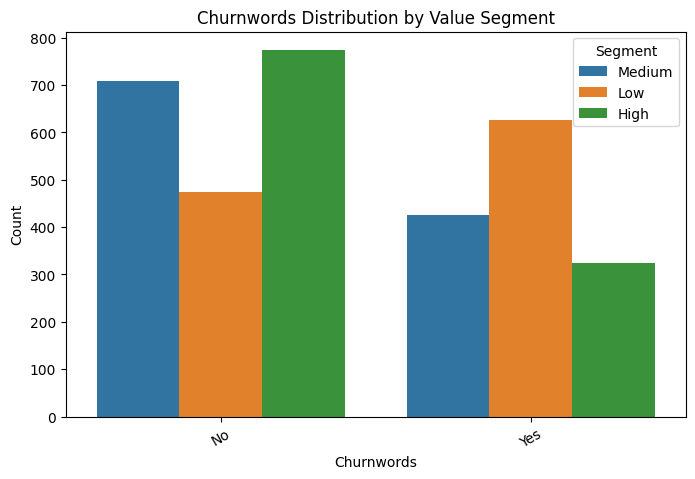

Contract_A    Month-to-month  One year  Two year
ValueSegment                                    
High                   0.188     0.525     0.592
Low                    0.475     0.135     0.056
Medium                 0.337     0.339     0.352


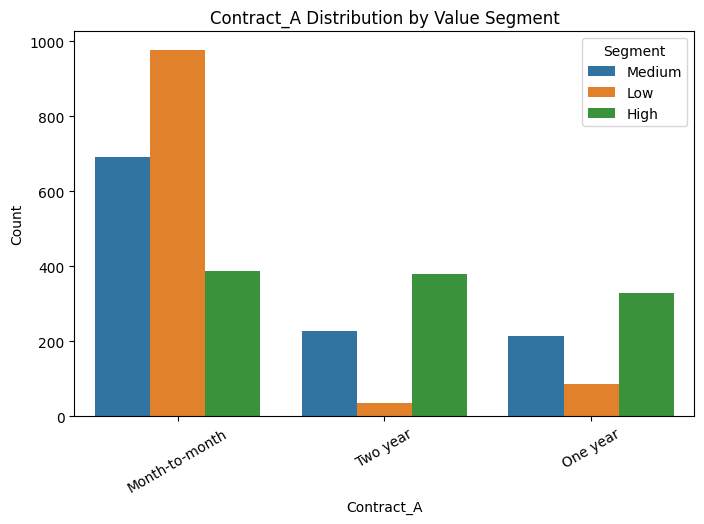

DependentsW      No    Yes
ValueSegment              
High          0.313  0.375
Low           0.354  0.265
Medium        0.333  0.360


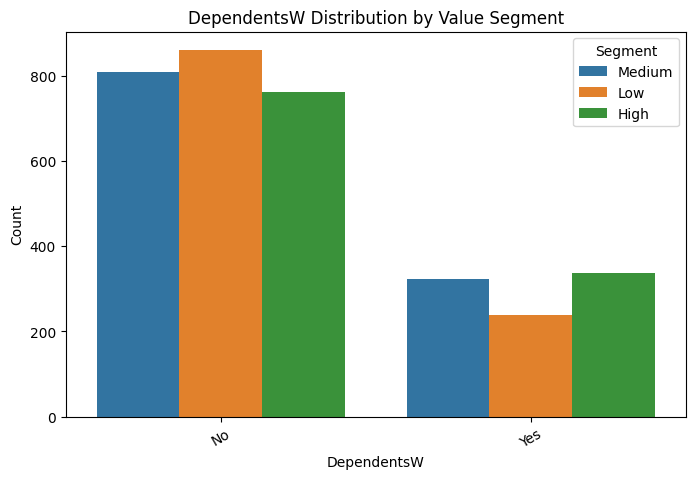

DeviceProtection_A     No  No internet service    Yes
ValueSegment                                         
High                0.248                 0.00  0.628
Low                 0.413                 0.52  0.108
Medium              0.339                 0.48  0.264


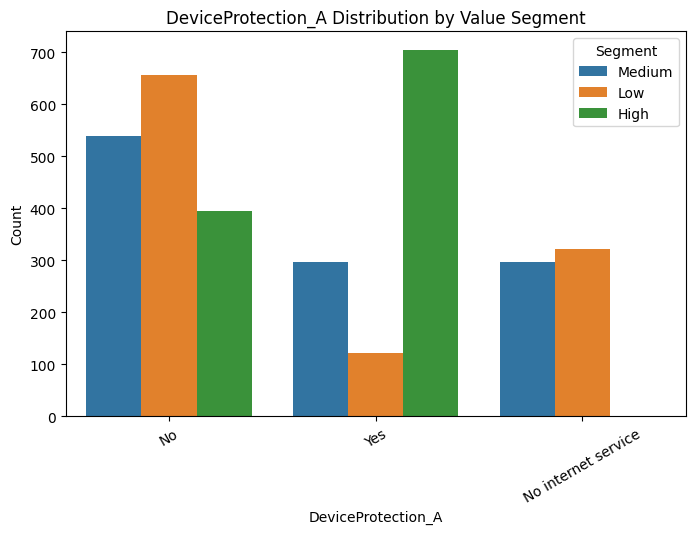

HasAutoPay    False   True
ValueSegment              
High          0.224  0.489
Low           0.451  0.148
Medium        0.325  0.363


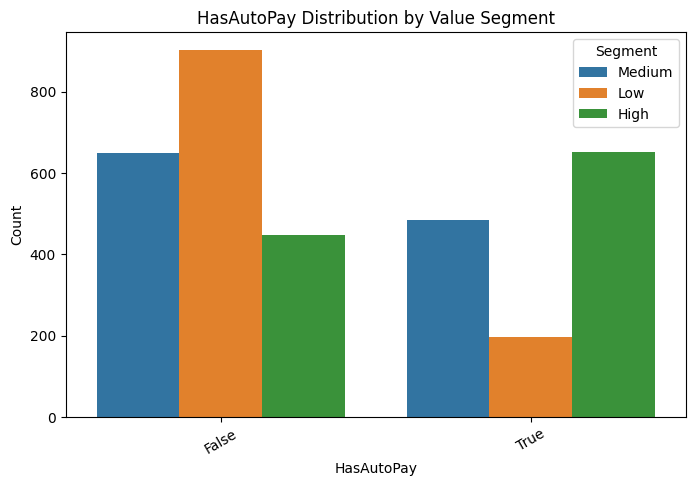

HasInternet   False   True
ValueSegment              
High           0.00  0.405
Low            0.52  0.287
Medium         0.48  0.308


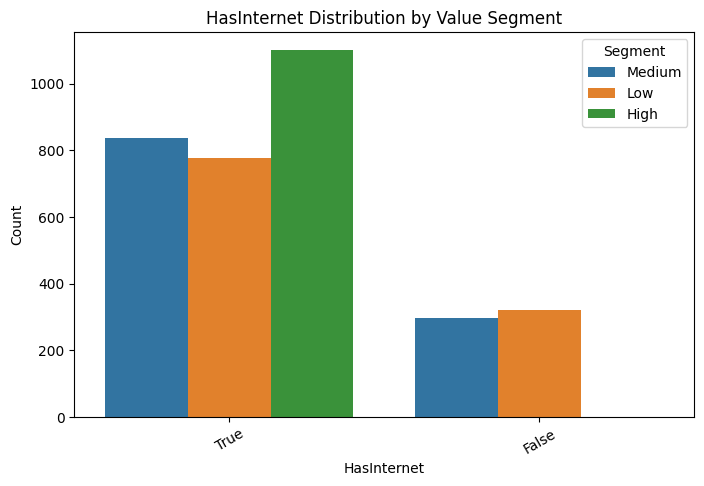

InternetService_A    DSL  Fiber optic    No
ValueSegment                               
High               0.329        0.457  0.00
Low                0.331        0.256  0.52
Medium             0.340        0.287  0.48


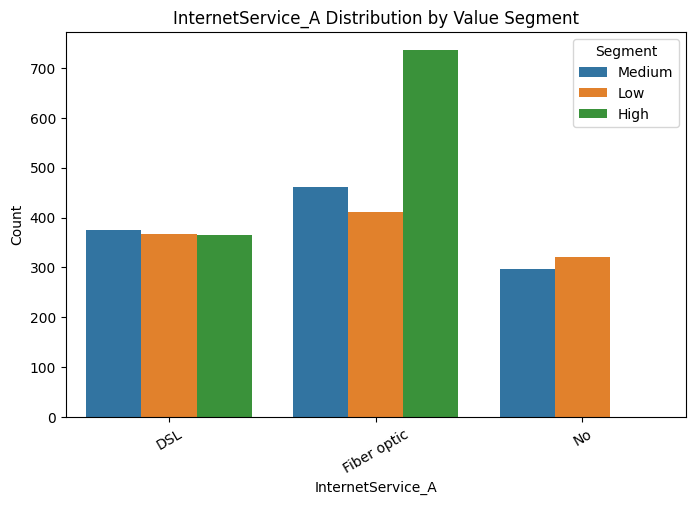

MultipleLinesw     No  No phone service    Yes
ValueSegment                                  
High            0.167             0.214  0.541
Low             0.490             0.380  0.138
Medium          0.343             0.407  0.321


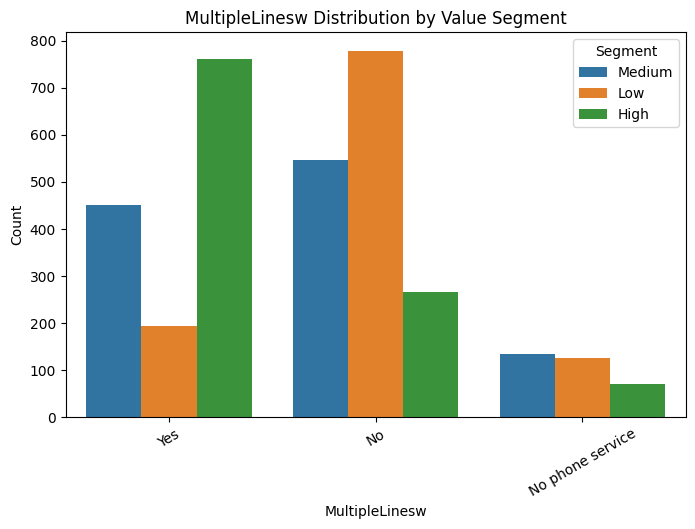

OnlineBackupW     No  No internet service    Yes
ValueSegment                                    
High           0.256                 0.00  0.628
Low            0.392                 0.52  0.130
Medium         0.352                 0.48  0.243


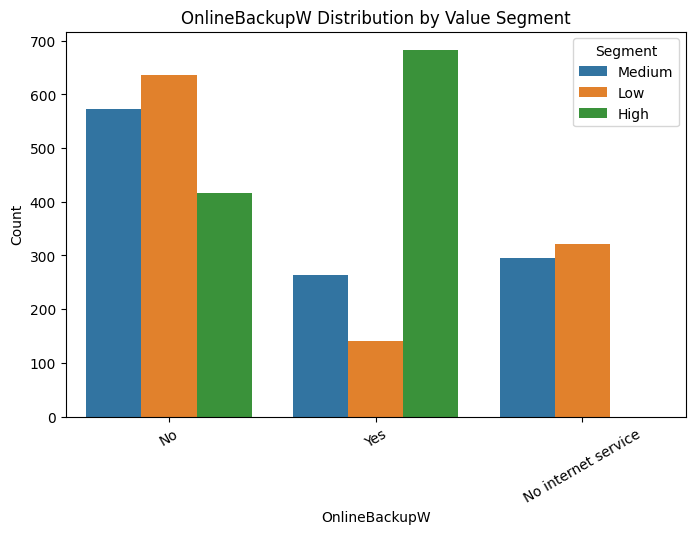

OnlineSecurityW     No  No internet service    Yes
ValueSegment                                      
High             0.305                 0.00  0.619
Low              0.367                 0.52  0.115
Medium           0.328                 0.48  0.267


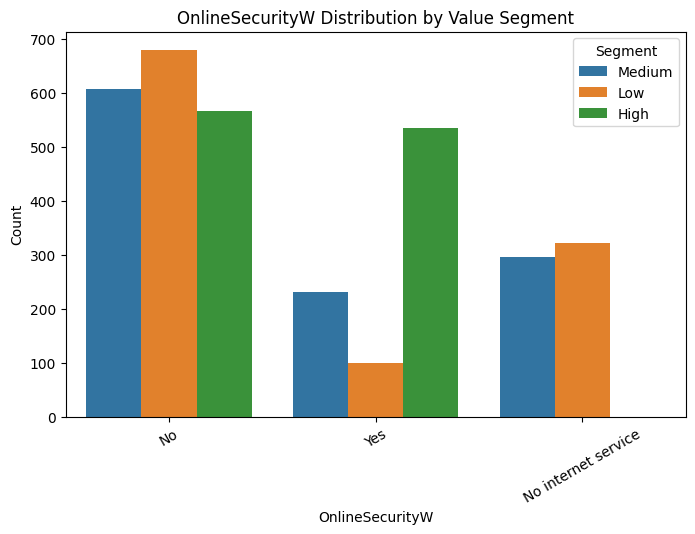

PaperlessBillingW     No    Yes
ValueSegment                   
High               0.255  0.375
Low                0.377  0.301
Medium             0.368  0.323


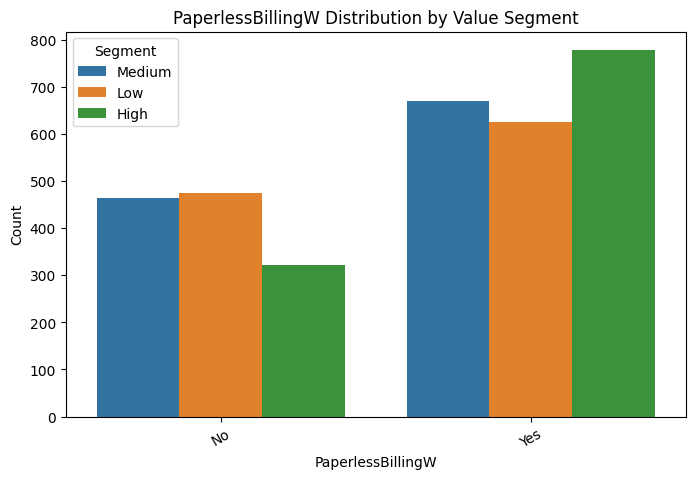

PartnerWord      No    Yes
ValueSegment              
High          0.213  0.478
Low           0.452  0.175
Medium        0.335  0.347


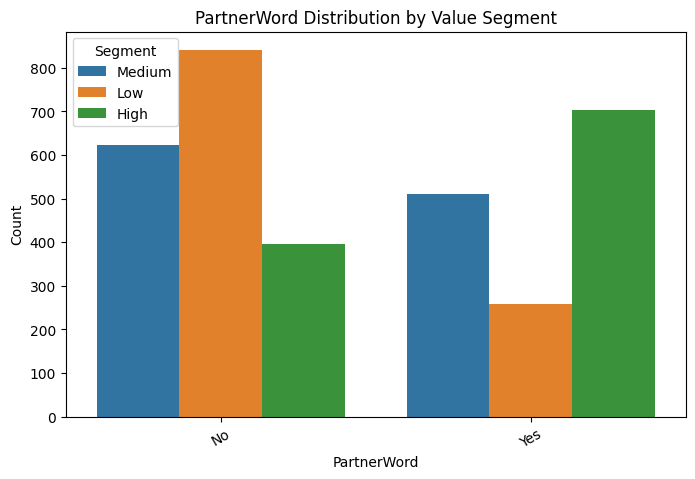

PaymentMethod_A  Bank transfer (automatic)  Credit card (automatic)  \
ValueSegment                                                          
High                                 0.479                    0.499   
Low                                  0.151                    0.146   
Medium                               0.370                    0.355   

PaymentMethod_A  Electronic check  Mailed check  
ValueSegment                                     
High                        0.288         0.114  
Low                         0.378         0.577  
Medium                      0.334         0.309  


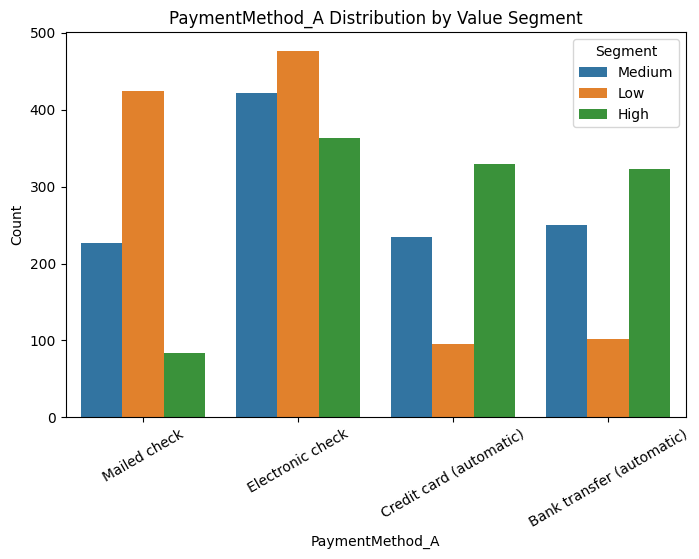

PhoneServicew     No    Yes
ValueSegment               
High           0.214  0.343
Low            0.380  0.324
Medium         0.407  0.333


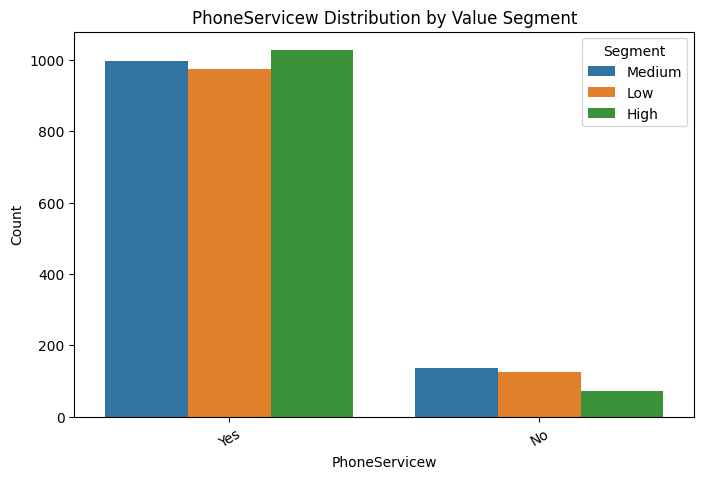

SeniorCitizen     NO    YES
ValueSegment               
High           0.310  0.422
Low            0.345  0.261
Medium         0.345  0.317


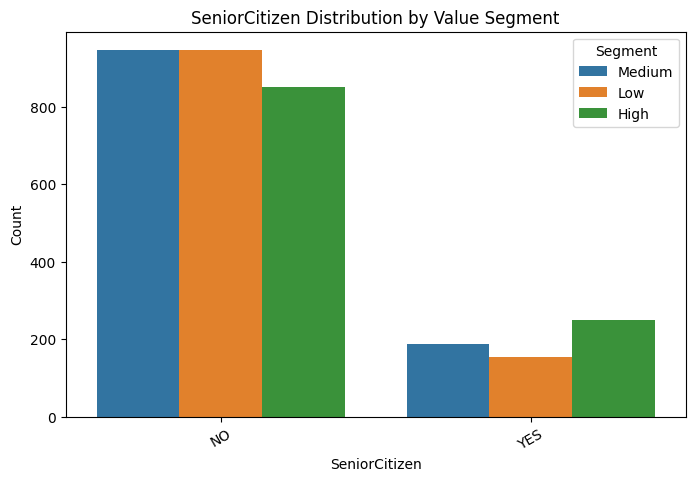

StreamingMovies_A     No  No internet service    Yes
ValueSegment                                        
High               0.237                 0.00  0.586
Low                0.421                 0.52  0.142
Medium             0.343                 0.48  0.272


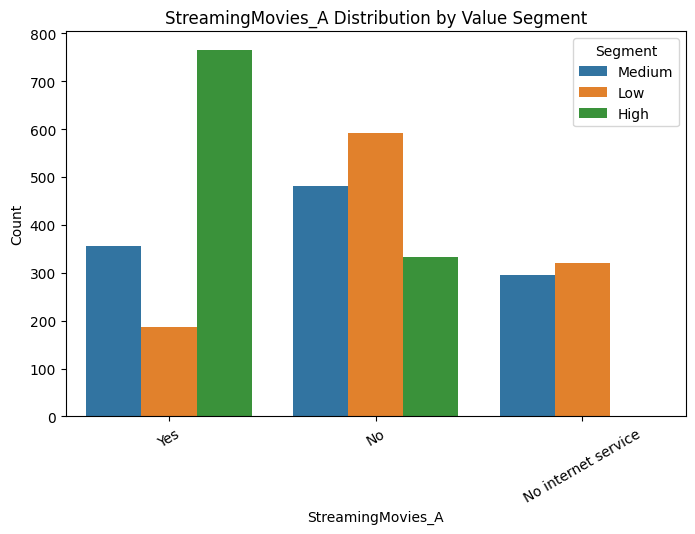

StreamingTV_A     No  No internet service    Yes
ValueSegment                                    
High           0.247                 0.00  0.579
Low            0.422                 0.52  0.138
Medium         0.332                 0.48  0.283


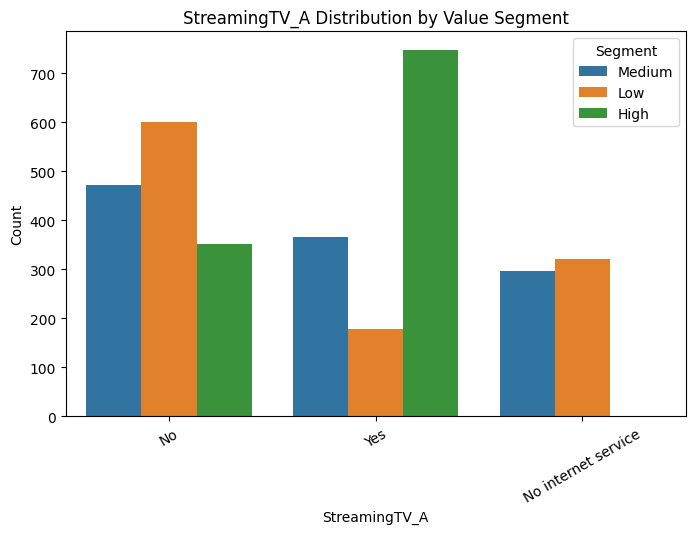

TechSupport_A     No  No internet service    Yes
ValueSegment                                    
High           0.305                 0.00  0.619
Low            0.363                 0.52  0.122
Medium         0.331                 0.48  0.259


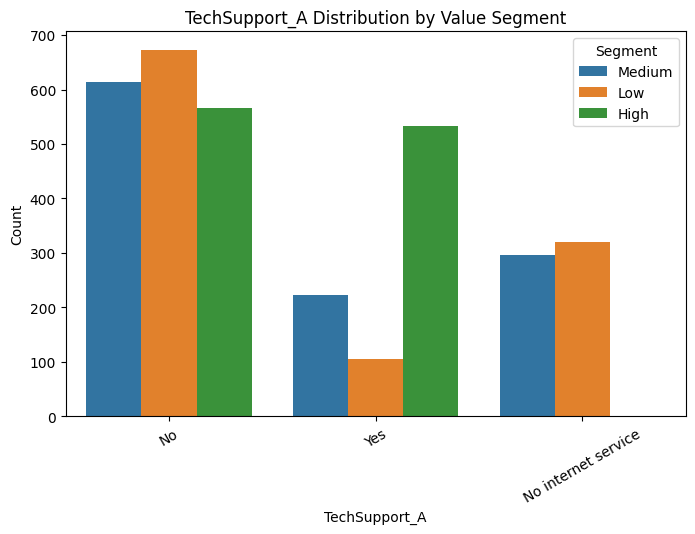

genderword    Female   Male
ValueSegment               
High           0.324  0.336
Low            0.324  0.335
Medium         0.352  0.329


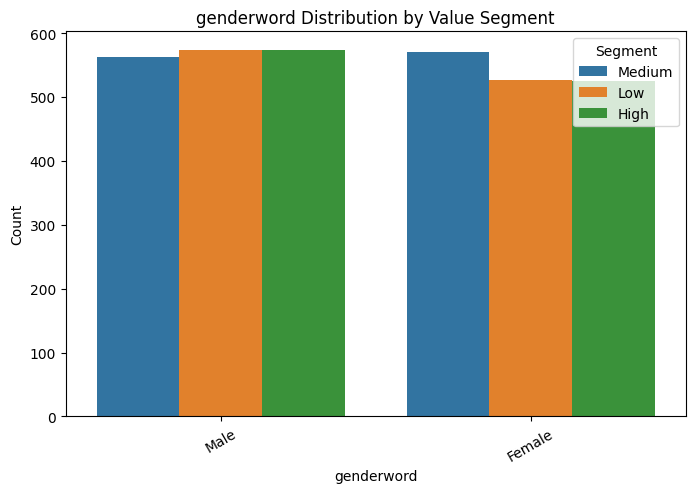

In [29]:
q4_df = q3_df.copy()
cat_cols = [col for col in encoding_map['Column'].drop_duplicates().values if ((col != 'customerID') & (col != 'ValueSegment'))]

for c in cat_cols:
    # Get the mapping for current column
    # if c in encoding_map['Column'].drop_duplicates().values:
    segment_map = dict(zip(
                    encoding_map[encoding_map['Column'] == "ValueSegment"]['Classes'],
                    encoding_map[encoding_map['Column'] == "ValueSegment"]['Label']
                ))
    value_map = dict(zip(
                    encoding_map[encoding_map['Column'] == c]['Classes'],
                    encoding_map[encoding_map['Column'] == c]['Label']
                ))
        # Create a temporary Series with original labels for plotting
    temp_df = q4_df.copy()
    temp_df["ValueSegment"] = temp_df["ValueSegment"].replace(segment_map)
    temp_df[c] = temp_df[c].replace(value_map)
    # ---- Print proportion table ----
    prop_table = temp_df.groupby(c, observed=False)["ValueSegment"]\
                                .value_counts(normalize=True) \
                                .unstack(fill_value=0).T
    print(prop_table.round(3))
        # ---- Plot histogram ----
    plt.figure(figsize=(8,5))
    sns.countplot(data=temp_df, x=c, hue="ValueSegment")
    plt.title(f"{c} Distribution by Value Segment")
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.legend(title="Segment")
    plt.xticks(rotation=30)
    plt.show()


add Bivariate analysis and strategy point in this

#### Question 5

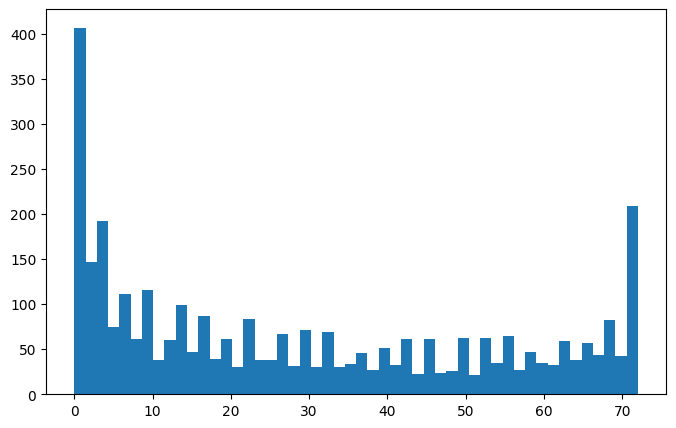

In [30]:
#save the time variable in `T `and event/status variable in `E` that we will use during the model fitting process
scaler = [t[1] for t in scaler_map if t[0] == 'tenure'][0]
data["tenure_org"] = scaler.inverse_transform(data[["tenure"]]) 

T = data["tenure_org"]
E = data["Churnwords"]

plt.figure(figsize=(8,5))
plt.hist(T, bins = 50)
plt.show()

<Axes: xlabel='timeline'>

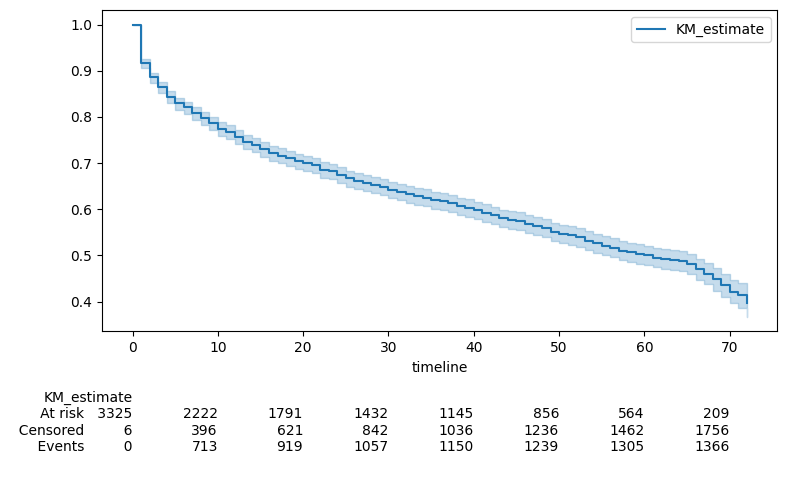

In [31]:
#fit Kaplan Meier Curve

plt.figure(figsize=(8,5))
kmf = KaplanMeierFitter()
kmf.fit(durations = T, event_observed = E)
kmf.plot_survival_function(at_risk_counts = True)

# #plot without CI
# kmf.survival_function_.plot()
# plt.title('Survival function')

<Axes: xlabel='timeline'>

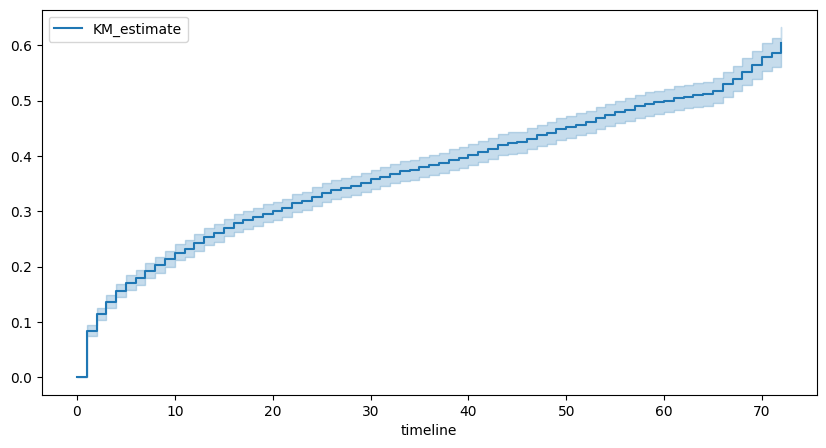

In [32]:
#Plot Failure
plt.figure(figsize=(10,5))
kmf.plot_cumulative_density()

In [33]:
#estimate Median survival times and 95% CI
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print("median: ", median_)
print("95% CI for the median:\n", median_confidence_interval_)

median:  61.0
95% CI for the median:
      KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                    56.0                    66.0


#### Question 6

In [34]:
# for i in data.select_dtypes(include=['object']).columns:
#     print(i, " -> ", data[i].nunique())

# cat_col = data.select_dtypes(include=['object']).columns
cat_col = [x for x in cat_col if (x!='customerID' and x!='Churnwords')]
cat_col 

['genderword',
 'SeniorCitizen',
 'PartnerWord',
 'DependentsW',
 'PhoneServicew',
 'MultipleLinesw',
 'PaperlessBillingW',
 'OnlineSecurityW',
 'OnlineBackupW',
 'DeviceProtection_A',
 'TechSupport_A',
 'StreamingTV_A',
 'StreamingMovies_A',
 'InternetService_A',
 'Contract_A',
 'PaymentMethod_A',
 'HasInternet',
 'HasAutoPay']

In [35]:
# defining plot function

def plot_survival_curve(column_split_by, figsize=(15,5), data=data):
  half_live = []
  value_map = dict(zip(
                    encoding_map[encoding_map['Column'] == column_split_by]['Classes'],
                    encoding_map[encoding_map['Column'] == column_split_by]['Label']
                ))
  cat_values = data[column_split_by].unique()  
  plt.figure(figsize=figsize)
  for i, cat_values in enumerate(cat_values):
    ax = plt.subplot(2, 2, i + 1)
    ix = data[column_split_by] == cat_values
    kmf.fit(T[ix], E[ix], label = f"{column_split_by} : {value_map.get(cat_values)}")
    kmf.plot_survival_function(ax = ax, legend = False, at_risk_counts = True)
    half_live.append({
         "category" : column_split_by
        ,"value" : cat_values
        ,"median" : kmf.median_survival_time_
        ,"KM_estimate_lower_0.95" :  median_survival_times(kmf.confidence_interval_).iloc[0][0]
        ,"KM_estimate_upper_0.95" :  median_survival_times(kmf.confidence_interval_).iloc[0][1]
      })

  plt.tight_layout()
  plt.show()
  halfLive_df = pd.DataFrame(half_live)
  halfLive_df['value'] = halfLive_df['value'].map(value_map).fillna(cat_values)
  print(halfLive_df.T)


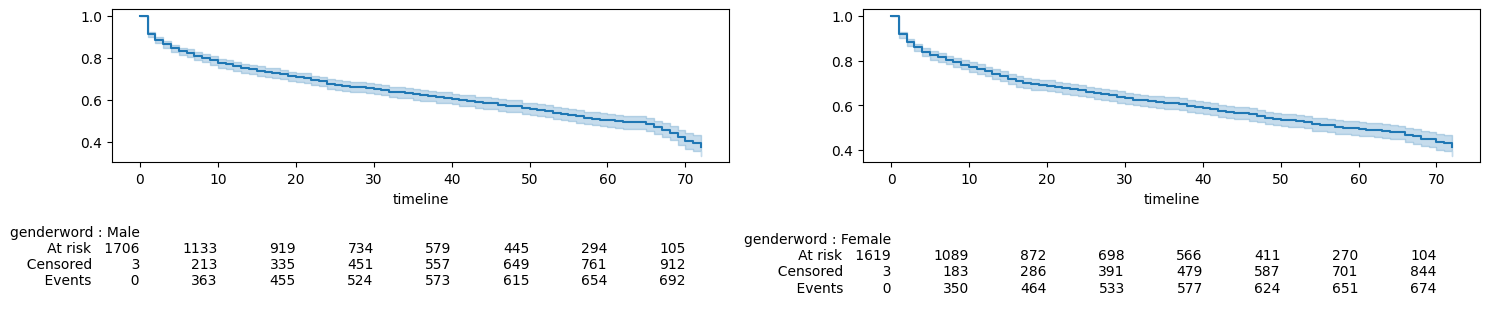

                                 0           1
category                genderword  genderword
value                         Male      Female
median                        61.0        59.0
KM_estimate_lower_0.95        55.0        53.0
KM_estimate_upper_0.95        67.0        67.0


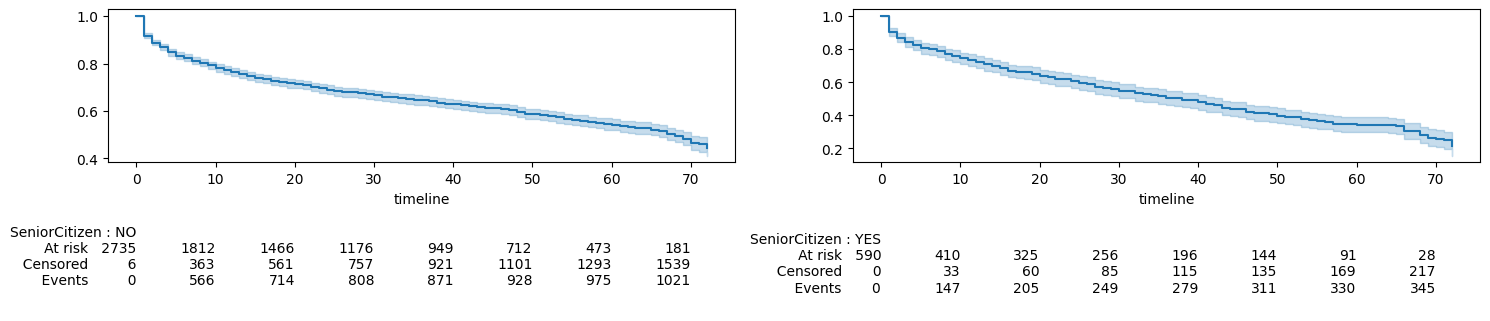

                                    0              1
category                SeniorCitizen  SeniorCitizen
value                              NO            YES
median                           68.0           38.0
KM_estimate_lower_0.95           65.0           32.0
KM_estimate_upper_0.95           70.0           43.0


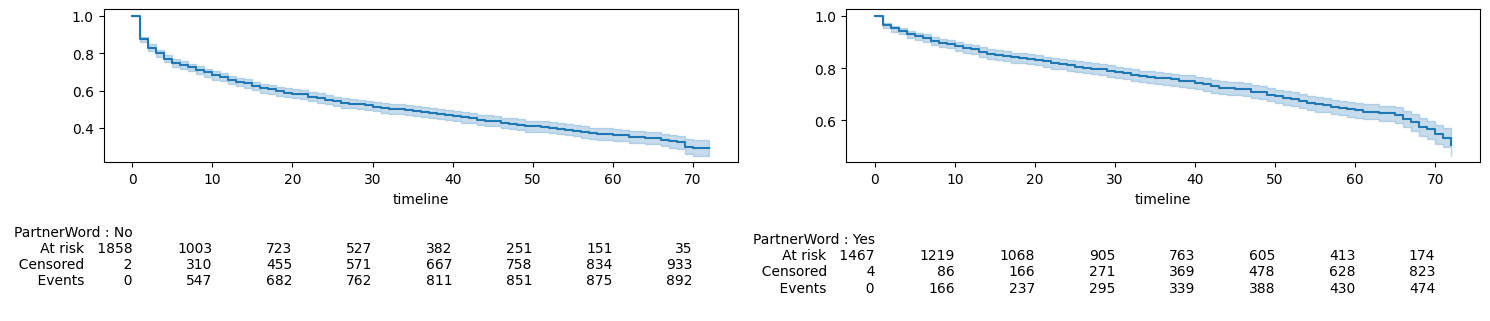

                                  0            1
category                PartnerWord  PartnerWord
value                            No          Yes
median                         34.0          inf
KM_estimate_lower_0.95         29.0         71.0
KM_estimate_upper_0.95         38.0          inf


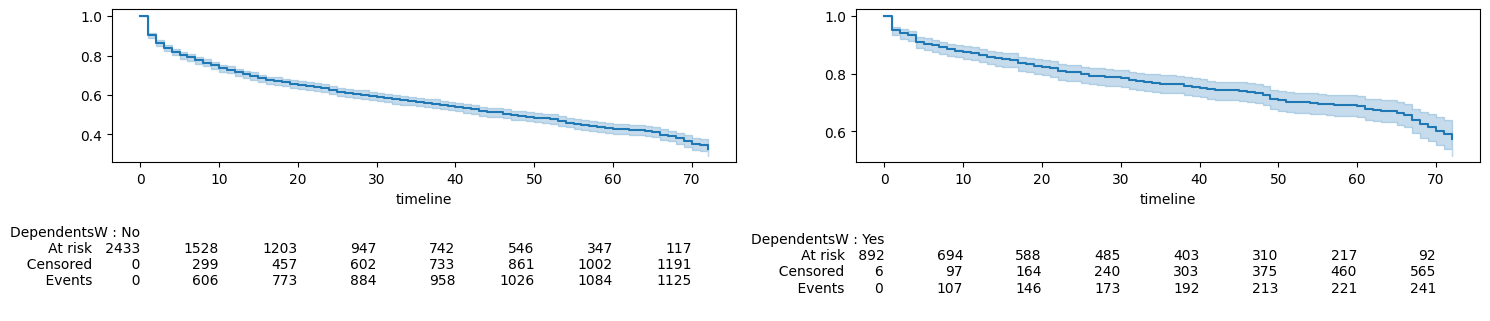

                                  0            1
category                DependentsW  DependentsW
value                            No          Yes
median                         47.0          inf
KM_estimate_lower_0.95         43.0          inf
KM_estimate_upper_0.95         53.0          inf


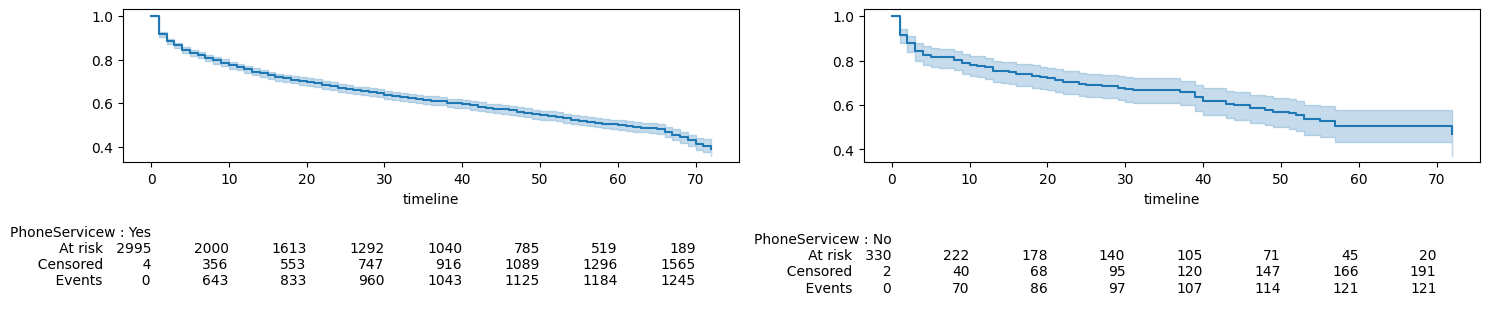

                                    0              1
category                PhoneServicew  PhoneServicew
value                             Yes             No
median                           60.0           72.0
KM_estimate_lower_0.95           55.0           51.0
KM_estimate_upper_0.95           66.0            inf


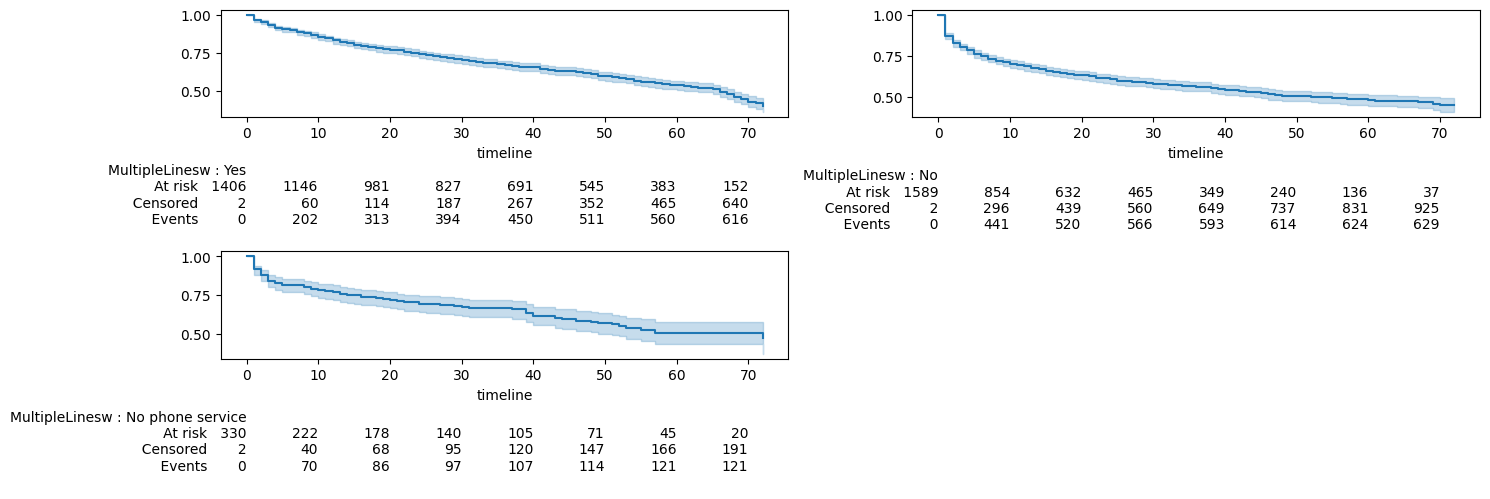

                                     0               1                 2
category                MultipleLinesw  MultipleLinesw    MultipleLinesw
value                              Yes              No  No phone service
median                            66.0            53.0              72.0
KM_estimate_lower_0.95            61.0            44.0              51.0
KM_estimate_upper_0.95            68.0            69.0               inf


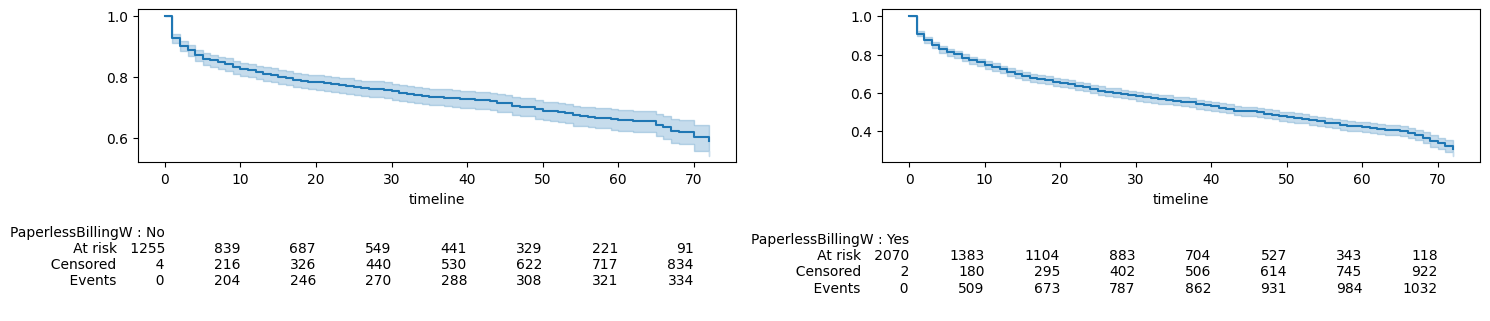

                                        0                  1
category                PaperlessBillingW  PaperlessBillingW
value                                  No                Yes
median                                inf               46.0
KM_estimate_lower_0.95                inf               41.0
KM_estimate_upper_0.95                inf               50.0


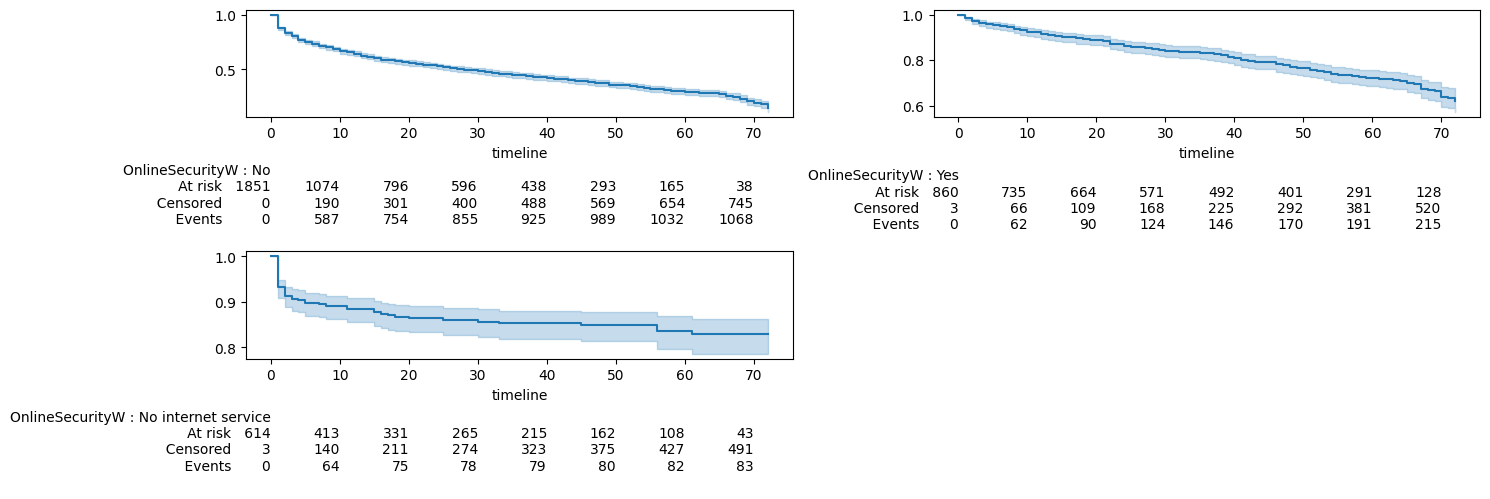

                                      0                1                    2
category                OnlineSecurityW  OnlineSecurityW      OnlineSecurityW
value                                No              Yes  No internet service
median                             28.0              inf                  inf
KM_estimate_lower_0.95             25.0              inf                  inf
KM_estimate_upper_0.95             32.0              inf                  inf


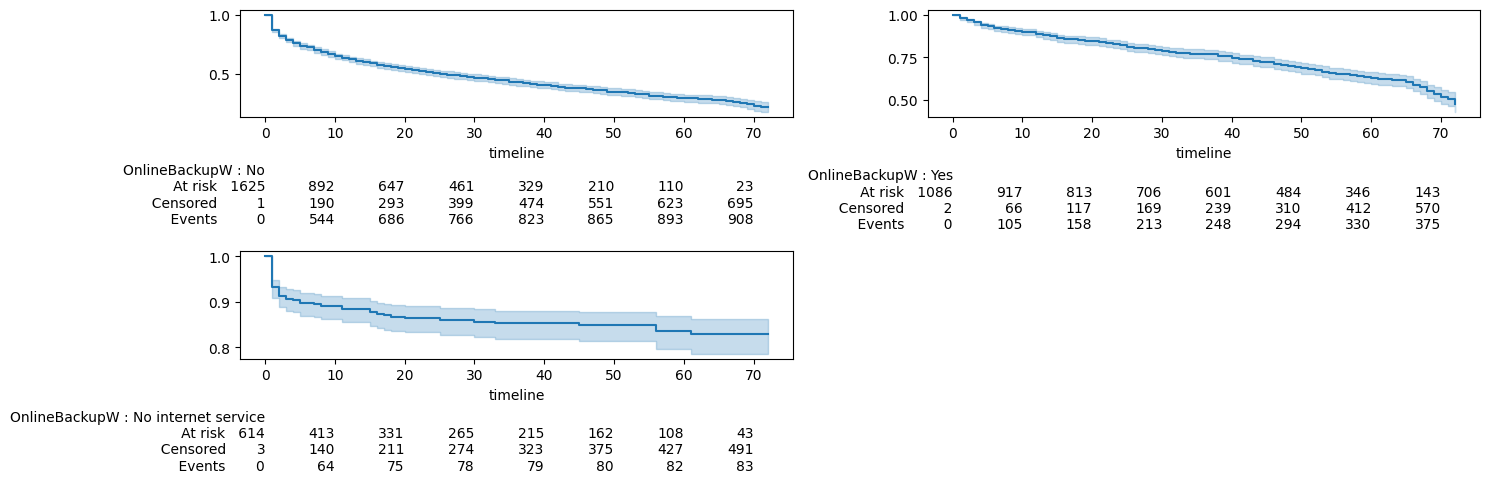

                                    0              1                    2
category                OnlineBackupW  OnlineBackupW        OnlineBackupW
value                              No            Yes  No internet service
median                           25.0           72.0                  inf
KM_estimate_lower_0.95           22.0           69.0                  inf
KM_estimate_upper_0.95           29.0            inf                  inf


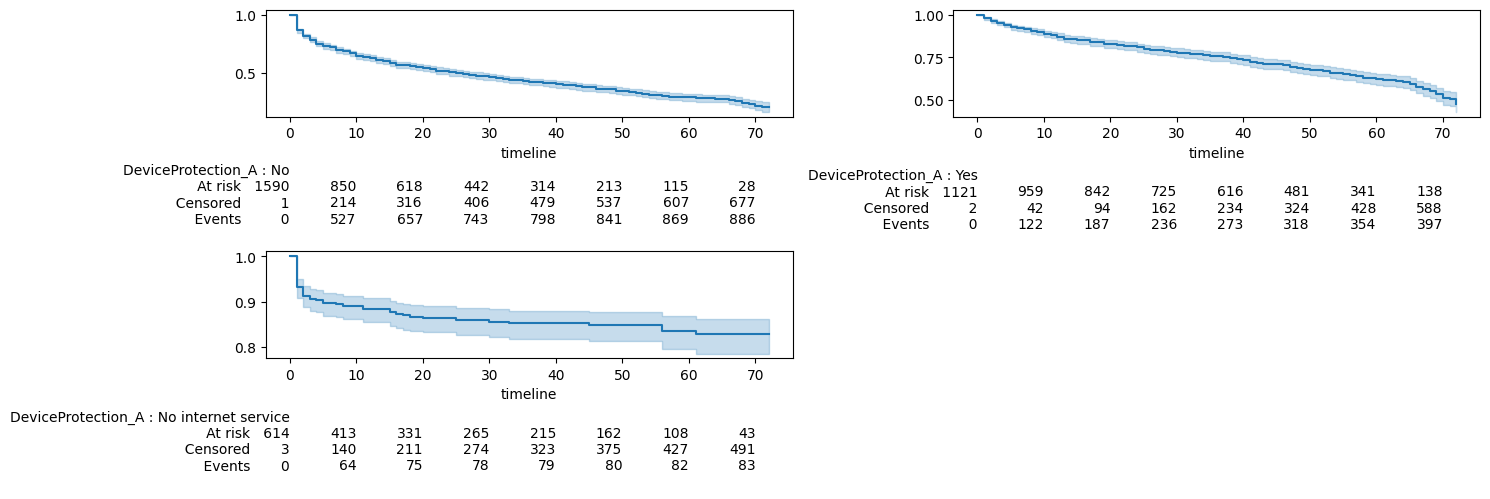

                                         0                   1  \
category                DeviceProtection_A  DeviceProtection_A   
value                                   No                 Yes   
median                                25.0                72.0   
KM_estimate_lower_0.95                22.0                69.0   
KM_estimate_upper_0.95                29.0                 inf   

                                          2  
category                 DeviceProtection_A  
value                   No internet service  
median                                  inf  
KM_estimate_lower_0.95                  inf  
KM_estimate_upper_0.95                  inf  


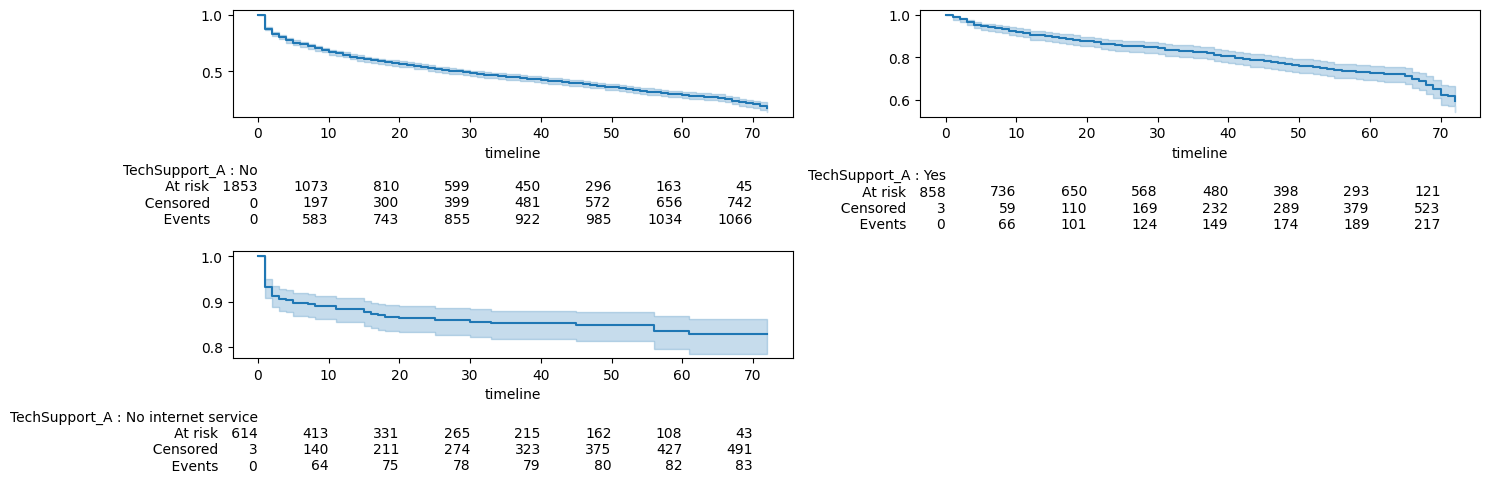

                                    0              1                    2
category                TechSupport_A  TechSupport_A        TechSupport_A
value                              No            Yes  No internet service
median                           28.0            inf                  inf
KM_estimate_lower_0.95           25.0            inf                  inf
KM_estimate_upper_0.95           32.0            inf                  inf


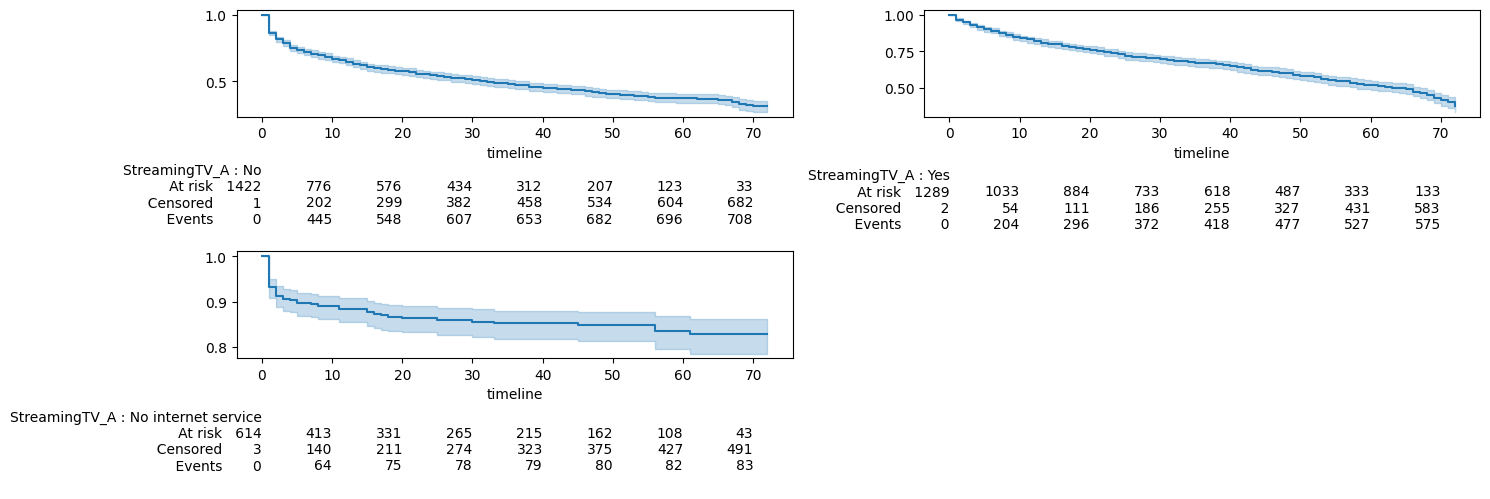

                                    0              1                    2
category                StreamingTV_A  StreamingTV_A        StreamingTV_A
value                              No            Yes  No internet service
median                           32.0           64.0                  inf
KM_estimate_lower_0.95           27.0           58.0                  inf
KM_estimate_upper_0.95           37.0           67.0                  inf


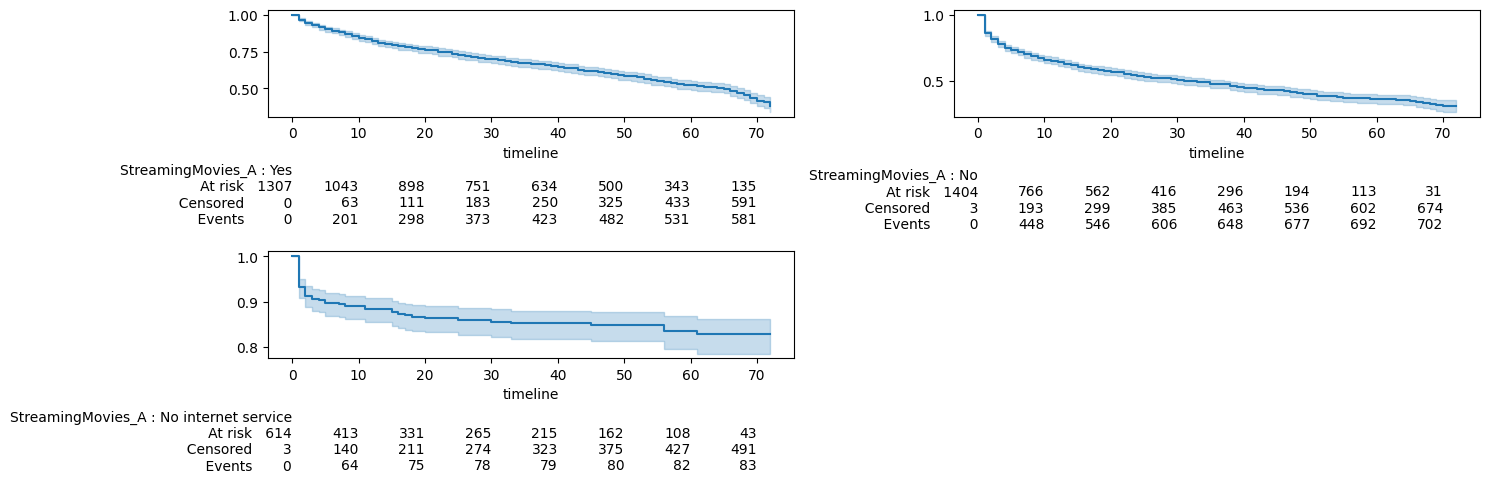

                                        0                  1  \
category                StreamingMovies_A  StreamingMovies_A   
value                                 Yes                 No   
median                               65.0               31.0   
KM_estimate_lower_0.95               58.0               26.0   
KM_estimate_upper_0.95               68.0               38.0   

                                          2  
category                  StreamingMovies_A  
value                   No internet service  
median                                  inf  
KM_estimate_lower_0.95                  inf  
KM_estimate_upper_0.95                  inf  


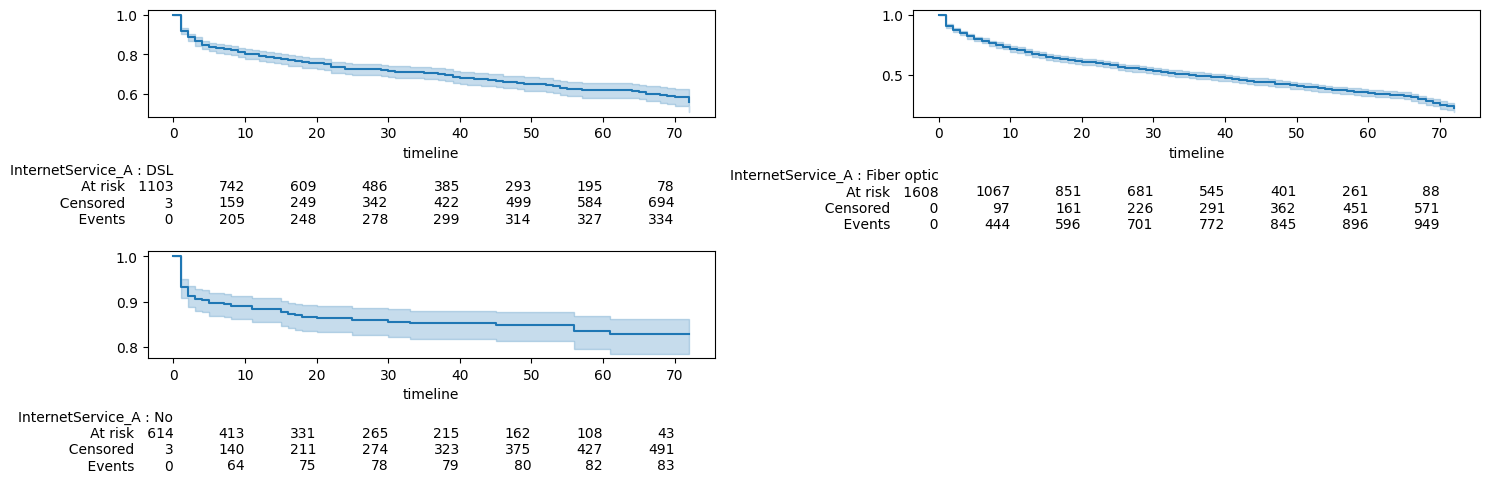

                                        0                  1  \
category                InternetService_A  InternetService_A   
value                                 DSL        Fiber optic   
median                                inf               35.0   
KM_estimate_lower_0.95                inf               32.0   
KM_estimate_upper_0.95                inf               41.0   

                                        2  
category                InternetService_A  
value                                  No  
median                                inf  
KM_estimate_lower_0.95                inf  
KM_estimate_upper_0.95                inf  


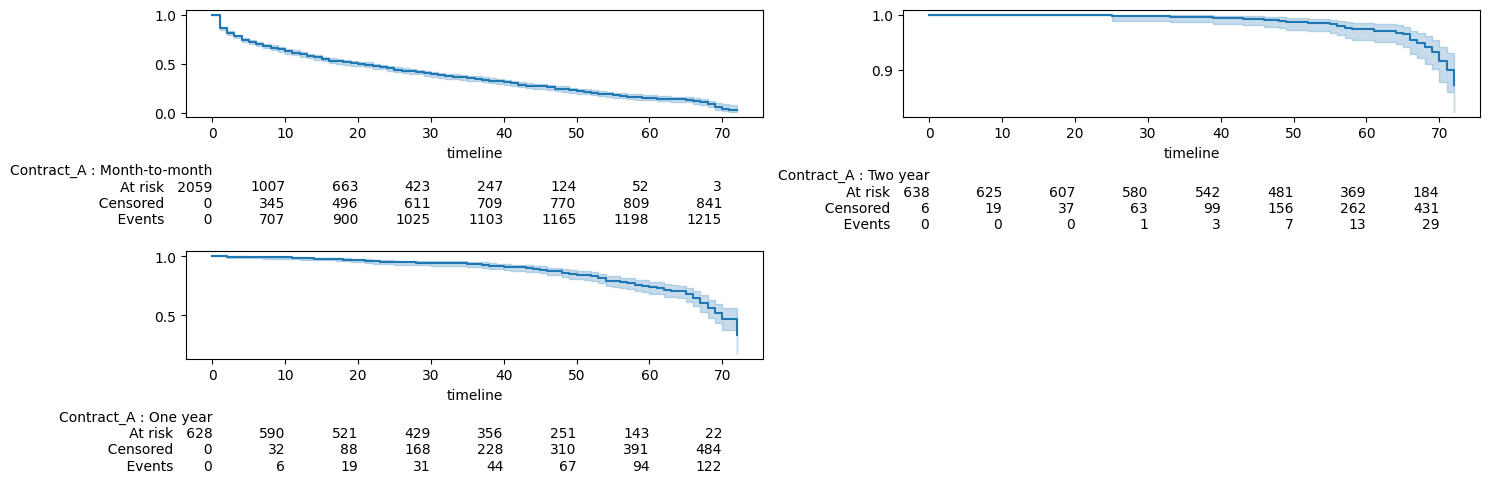

                                     0           1           2
category                    Contract_A  Contract_A  Contract_A
value                   Month-to-month    Two year    One year
median                            20.0         inf        70.0
KM_estimate_lower_0.95            18.0         inf        68.0
KM_estimate_upper_0.95            22.0         inf         inf


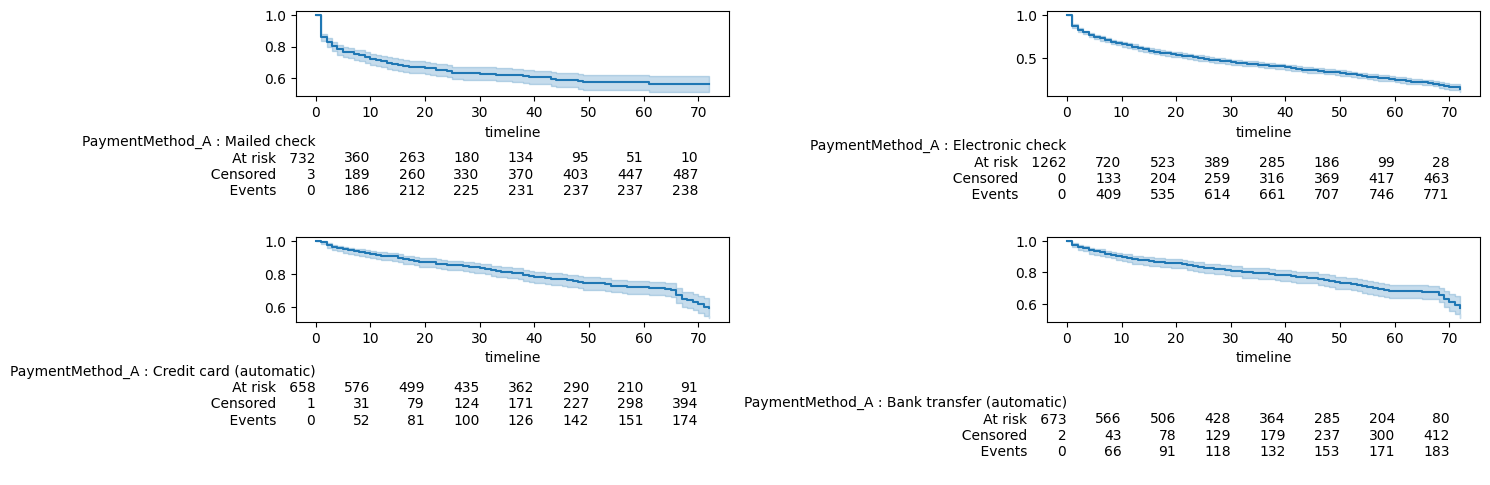

                                      0                 1  \
category                PaymentMethod_A   PaymentMethod_A   
value                      Mailed check  Electronic check   
median                              inf              25.0   
KM_estimate_lower_0.95              inf              21.0   
KM_estimate_upper_0.95              inf              28.0   

                                              2                          3  
category                        PaymentMethod_A            PaymentMethod_A  
value                   Credit card (automatic)  Bank transfer (automatic)  
median                                      inf                        inf  
KM_estimate_lower_0.95                      inf                        inf  
KM_estimate_upper_0.95                      inf                        inf  


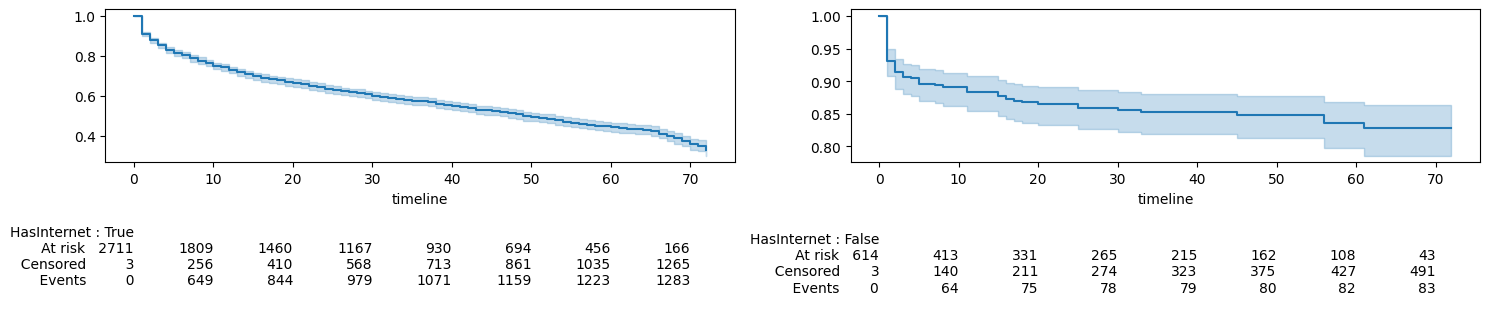

                                  0            1
category                HasInternet  HasInternet
value                          True        False
median                         49.0          inf
KM_estimate_lower_0.95         46.0          inf
KM_estimate_upper_0.95         54.0          inf


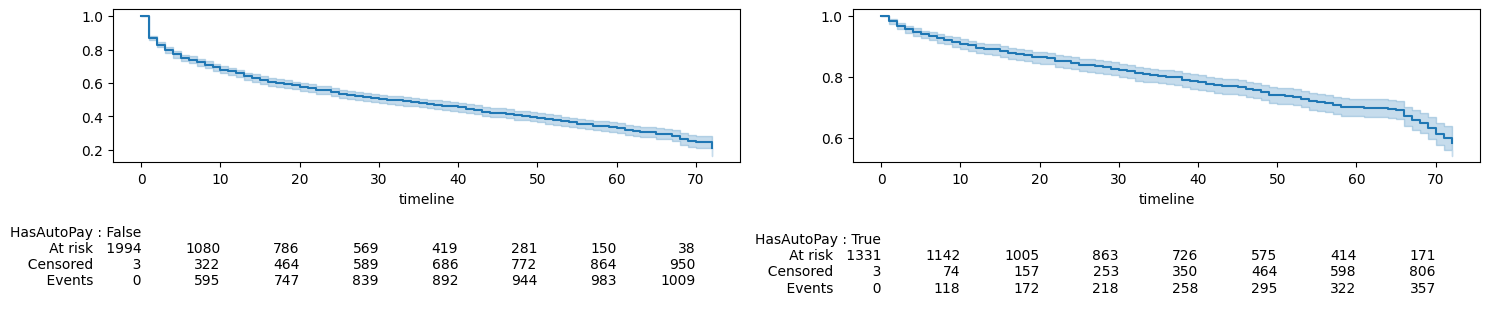

                                 0           1
category                HasAutoPay  HasAutoPay
value                        False        True
median                        31.0         inf
KM_estimate_lower_0.95        27.0         inf
KM_estimate_upper_0.95        36.0         inf


In [36]:
# for each Cat Column
for i in cat_col:
   plot_survival_curve(i)

#### Question 7

In [37]:
q7_df = data[['tenure', 'Churnwords'] + cat_col].copy()

# Fit Cox model
cph = CoxPHFitter()
# Use the cleaned q7_df for fitting
cph.fit(q7_df, duration_col='tenure', event_col='Churnwords')
cph.print_summary()          
# Model summary in notebook
# cph.summary.to_csv('cox_model_summary.csv')    # For assignment


<lifelines.CoxPHFitter: fitted with 3331 total observations, 1955 right-censored observations>
             duration col = 'tenure'
                event col = 'Churnwords'
      baseline estimation = breslow
   number of observations = 3331
number of events observed = 1376
   partial log-likelihood = -9273.66
         time fit was run = 2025-09-12 06:58:34 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
genderword         -0.05      0.95      0.05           -0.16            0.06                0.86                1.06
SeniorCitizen      -0.03      0.97      0.07           -0.16            0.10                0.85                1.11
PartnerWord        -0.51      0.60      0.07           -0.64           -0.39                0.53                0.68
DependentsW         0.04      1.04      0.08           -0.12            0.20                0.89                1.22
PhoneServicew      -0.00      1.00      0.12           -0.23            0.23                0.79                1.25
MultipleLinesw     -0.26      0.77      0.03           -0.32           -0.20                0.73                0.82
PaperlessBillingW   0.23      1.26      0.07            0.10            0.36                1.11                1.44
OnlineSecurityW    -0.26      0.77      0.04           -0.34           -0.18                0.71                0.83
OnlineBackupW      -0.30      0.74      0.03           -0.36           -0.24                0.70                0.79
DeviceProtection_A -0.14      0.87      0.03           -0.20           -0.08                0.82                0.93
TechSupport_A      -0.19      0.83      0.04           -0.26           -0.11                0.77                0.90
StreamingTV_A      -0.05      0.95      0.03           -0.11            0.02                0.90                1.02
StreamingMovies_A  -0.08      0.93      0.03           -0.14           -0.01                0.87                0.99
InternetService_A   0.26      1.29      0.09            0.09            0.42                1.09                1.53
Contract_A         -1.57      0.21      0.08           -1.72           -1.42                0.18                0.24
PaymentMethod_A     0.06      1.06      0.07           -0.07            0.19                0.93                1.21
HasInternet         0.56      1.75      0.18            0.21            0.90                1.23                2.47
HasAutoPay         -0.43      0.65      0.13           -0.68           -0.17                0.51                0.84

                    cmp to      z      p  -log2(p)
covariate                                         
genderword            0.00  -0.93   0.35      1.50
SeniorCitizen         0.00  -0.44   0.66      0.59
PartnerWord           0.00  -7.86 <0.005     47.93
DependentsW           0.00   0.52   0.61      0.72
PhoneServicew         0.00  -0.03   0.98      0.03
MultipleLinesw        0.00  -8.26 <0.005     52.62
PaperlessBillingW     0.00   3.46 <0.005     10.87
OnlineSecurityW       0.00  -6.70 <0.005     35.48
OnlineBackupW         0.00  -9.40 <0.005     67.27
DeviceProtection_A    0.00  -4.33 <0.005     16.06
TechSupport_A         0.00  -4.77 <0.005     19.07
StreamingTV_A         0.00  -1.49   0.14      2.87
StreamingMovies_A     0.00  -2.38   0.02      5.85
InternetService_A     0.00   3.02 <0.005      8.63
Contract_A            0.00 -20.36 <0.005    303.67
PaymentMethod_A       0.00   0.93   0.35      1.50
HasInternet           0.00   3.15 <0.005      9.24
HasAutoPay            0.00  -3.30 <0.005     10.03
---
Concordance = 0.85
Partial AIC = 18583.33
log-likelihood ratio test = 2215.12 on 18 df
-log2(p) of ll-ratio test = inf

Commenting on coefficients:
- Positive coef: increases hazard (higher churn risk).
- Negative coef: reduces hazard (retention effect).

#### Question 8

In [38]:
cat_col

['genderword',
 'SeniorCitizen',
 'PartnerWord',
 'DependentsW',
 'PhoneServicew',
 'MultipleLinesw',
 'PaperlessBillingW',
 'OnlineSecurityW',
 'OnlineBackupW',
 'DeviceProtection_A',
 'TechSupport_A',
 'StreamingTV_A',
 'StreamingMovies_A',
 'InternetService_A',
 'Contract_A',
 'PaymentMethod_A',
 'HasInternet',
 'HasAutoPay']

In [39]:
# Select predictors and prepare data
poisson_predictors = cat_col
# The target variable for Poisson regression is the count of events, which is 'Cust_Calls'
target_variable = 'Cust_Calls'

# Create the dataframe for the Poisson model
pois_df = data_bckup_df[poisson_predictors + [target_variable]].copy()

# Build formula text to pass using column names
formula_parts = [c for c in poisson_predictors if c != target_variable]
formula = target_variable + ' ~ ' + ' + '.join(formula_parts)
print("Generated formula string : \n", formula)


Generated formula string : 
 Cust_Calls ~ genderword + SeniorCitizen + PartnerWord + DependentsW + PhoneServicew + MultipleLinesw + PaperlessBillingW + OnlineSecurityW + OnlineBackupW + DeviceProtection_A + TechSupport_A + StreamingTV_A + StreamingMovies_A + InternetService_A + Contract_A + PaymentMethod_A + HasInternet + HasAutoPay


In [40]:
# Fit Poisson regression
model = smf.poisson(formula, data=pois_df)
result = model.fit()           
# Model summary for report
print(result.summary())    

         Current function value: 1.496344
         Iterations: 35
                          Poisson Regression Results                          
Dep. Variable:             Cust_Calls   No. Observations:                 3331
Model:                        Poisson   Df Residuals:                     3310
Method:                           MLE   Df Model:                           20
Date:                Fri, 12 Sep 2025   Pseudo R-squ.:                 0.08159
Time:                        12:28:36   Log-Likelihood:                -4984.3
converged:                      False   LL-Null:                       -5427.1
Covariance Type:            nonrobust   LLR p-value:                9.101e-175
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                      0.3058   6.85e+05   4.47e-07     

In [41]:
# Example: predict for a random observation
obs = pois_df.sample(1, random_state=42)
pred_lambda = result.get_prediction(obs).predicted[0]
print("Actual Observation :", obs.Cust_Calls.values[0], "\nPredicted Lambda :", pred_lambda)

Actual Observation : 2 
Predicted Lambda : 2.421926141968453


In [42]:
# Compute full Poisson distribution for that observation
call_range = np.arange(0, 15)
poisson_probs = sp_poisson.pmf(call_range, pred_lambda)
for k, p in zip(call_range, poisson_probs):
    print(f"P(calls={k}) = {p:.3f}")

P(calls=0) = 0.089
P(calls=1) = 0.215
P(calls=2) = 0.260
P(calls=3) = 0.210
P(calls=4) = 0.127
P(calls=5) = 0.062
P(calls=6) = 0.025
P(calls=7) = 0.009
P(calls=8) = 0.003
P(calls=9) = 0.001
P(calls=10) = 0.000
P(calls=11) = 0.000
P(calls=12) = 0.000
P(calls=13) = 0.000
P(calls=14) = 0.000


#### Question 9

In [43]:
df = data_bckup_df.copy()
# Keep predictors the brief expects + multi-category factors
predictors = [
    'tenure','MonthlyCharges','TotalCharges',
    'SeniorCitizen','PartnerWord','DependentsW','PhoneServicew','MultipleLinesw',
    'PaperlessBillingW','OnlineSecurityW','OnlineBackupW','DeviceProtection_A',
    'TechSupport_A','StreamingTV_A','StreamingMovies_A'
]
cats = ['InternetService_A','Contract_A','PaymentMethod_A']

# Drop rows with any missing values in the model columns
use_cols = ['Cust_Calls'] + predictors + cats
mdf = df[use_cols].dropna().copy()
print("Modeling frame:", mdf.shape)
mdf.head(3)

Modeling frame: (3331, 19)


,Cust_Calls,tenure,MonthlyCharges,TotalCharges,SeniorCitizen,PartnerWord,DependentsW,PhoneServicew,MultipleLinesw,PaperlessBillingW,OnlineSecurityW,OnlineBackupW,DeviceProtection_A,TechSupport_A,StreamingTV_A,StreamingMovies_A,InternetService_A,Contract_A,PaymentMethod_A
0,1,9,59.9,542.40,NO,No,No,Yes,Yes,No,No,No,No,No,No,Yes,DSL,Month-to-month,Mailed check
1,1,4,73.9,280.85,NO,No,No,Yes,No,Yes,No,No,Yes,No,No,No,Fiber optic,Month-to-month,Electronic check
2,1,13,98.0,1237.85,YES,Yes,No,Yes,No,Yes,No,Yes,Yes,No,Yes,Yes,Fiber optic,Month-to-month,Electronic check


In [44]:
formula = "Cust_Calls ~ " + " + ".join(predictors + [f"C({c})" for c in cats])
pois = smf.glm(formula, data=mdf, family=sm.families.Poisson()).fit()
print(pois.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:             Cust_Calls   No. Observations:                 3331
Model:                            GLM   Df Residuals:                     3308
Model Family:                 Poisson   Df Model:                           22
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4784.5
Date:                Fri, 12 Sep 2025   Deviance:                       2544.9
Time:                        12:28:36   Pearson chi2:                 2.77e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3201
Covariance Type:            nonrobust                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [45]:
# Pearson Chi-square / df (overdispersion diagnostic)
pearson_chi2 = (pois.resid_pearson**2).sum()
dispersion = pearson_chi2 / pois.df_resid
print("\n[Poisson] Pearson Chi2/df =", round(dispersion,3))



[Poisson] Pearson Chi2/df = 0.837


In [46]:
# Omnibus deviance test (null vs model)
dev = getattr(pois, "deviance", np.nan)
null_dev = getattr(pois, "null_deviance", np.nan)
df_model = pois.df_model

LR = null_dev - dev
pval = 1 - chi2.cdf(LR, df_model)
print(f"[Omnibus] Null deviance={null_dev:.2f}, Model deviance={dev:.2f}, "
      f"Chi2={LR:.2f} (df={int(df_model)}), p={pval:.3e}")

if null_dev > 0:
    pseudo_r2 = 1 - dev/null_dev
    print("[Pseudo R^2] =", round(pseudo_r2, 3))


[Omnibus] Null deviance=3830.09, Model deviance=2544.93, Chi2=1285.15 (df=22), p=0.000e+00
[Pseudo R^2] = 0.336


In [47]:
# Full Poisson distribution for one observation
row = mdf.sample(1, random_state=7)
mu = float(pois.predict(row))
K = max(18, int(mu + 5*np.sqrt(mu)))
k = np.arange(0, K+1)
pmf_tbl = pd.DataFrame({"k": k, "PMF": pois_dist.pmf(k, mu), "CDF": pois_dist.cdf(k, mu)})

print(f"[Selected observation index: {row.index[0]}] predicted mean mu = {mu:.3f}")
print(pmf_tbl.head(20))


[Selected observation index: 95] predicted mean mu = 0.946
     k           PMF       CDF
0    0  3.882098e-01  0.388210
1    1  3.673277e-01  0.755538
2    2  1.737845e-01  0.929322
3    3  5.481215e-02  0.984134
4    4  1.296594e-02  0.997100
5    5  2.453699e-03  0.999554
6    6  3.869521e-04  0.999941
7    7  5.230537e-05  0.999993
8    8  6.186479e-06  0.999999
9    9  6.504115e-07  1.000000
10  10  6.154253e-08  1.000000
11  11  5.293829e-09  1.000000
12  12  4.174225e-10  1.000000
13  13  3.038223e-11  1.000000
14  14  2.053425e-12  1.000000
15  15  1.295313e-13  1.000000
16  16  7.660232e-15  1.000000
17  17  4.263637e-16  1.000000
18  18  2.241274e-17  1.000000


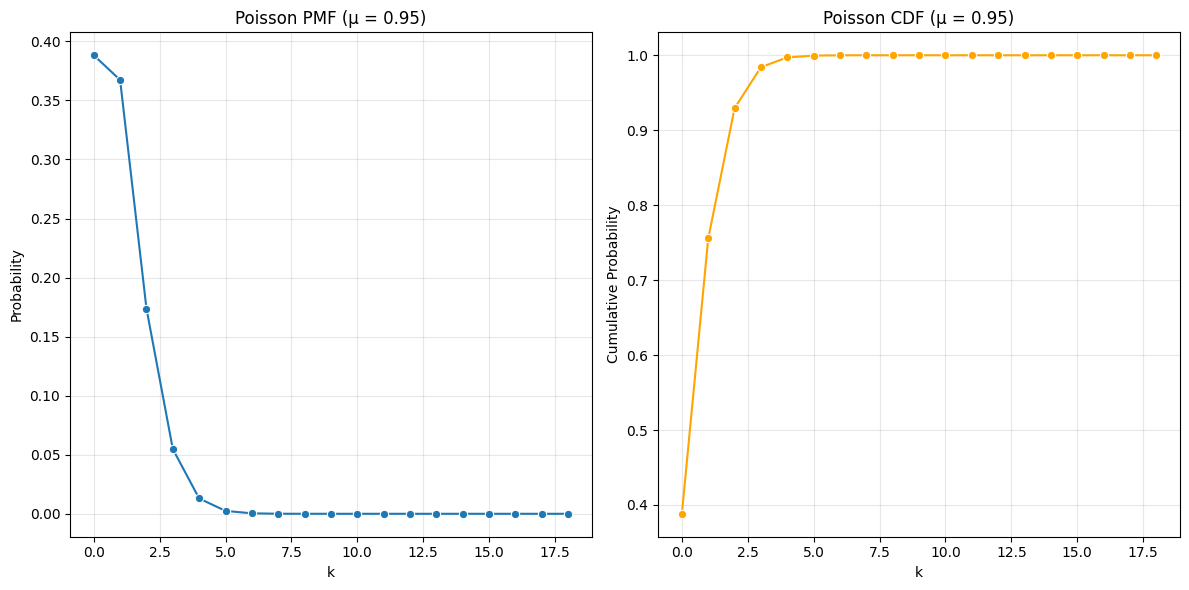

In [48]:
plt.figure(figsize=(12, 6))

# Plot PMF
plt.subplot(1, 2, 1)
sns.lineplot(data=pmf_tbl, x='k', y='PMF', marker='o')
plt.title(f'Poisson PMF (μ = {mu:.2f})')
plt.xlabel('k')
plt.ylabel('Probability')
plt.grid(True, alpha=0.3)

# Plot CDF
plt.subplot(1, 2, 2)
sns.lineplot(data=pmf_tbl, x='k', y='CDF', marker='o', color='orange')
plt.title(f'Poisson CDF (μ = {mu:.2f})')
plt.xlabel('k')
plt.ylabel('Cumulative Probability')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()